In [3]:
import os
import numpy as np
import pandas as pd
import json
import logging
import re
import holidays
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error
from scipy import stats
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge, PoissonRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


# utility
from dotenv import load_dotenv
from sqlalchemy import create_engine
from tqdm import tqdm
from IPython.core.display import display, HTML, clear_output
import warnings
from sklearn.exceptions import ConvergenceWarning


warnings.filterwarnings("ignore", category=ConvergenceWarning)
tqdm.pandas()
warnings.filterwarnings("ignore")
display(HTML("<style>.container { width:90% !important; }</style>"))
logging.getLogger('cmdstanpy').setLevel(logging.CRITICAL)



load_dotenv()
db_config = {
    'user': os.getenv('DB_USER'),
    'password': os.getenv('DB_PASSWORD'),
    'host': os.getenv('DB_HOST'),
    'port': os.getenv('DB_PORT'),
    'database': os.getenv('DB_NAME')
}

db_url = f"mysql+pymysql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"
engine = create_engine(db_url, connect_args={'connect_timeout': 600})

/var/folders/x2/3p459hxs50n3j_bqtz00yclm0000gn/T/ipykernel_20154/632046093.py:26: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, clear_output
/var/folders/x2/3p459hxs50n3j_bqtz00yclm0000gn/T/ipykernel_20154/632046093.py:26: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, clear_output


In [4]:
finbert_query = """
    SELECT * FROM daily_finbert_sentiment
"""
feature_query = """
    SELECT * FROM feature_data
"""

In [5]:

with engine.connect() as connection:
    sentiment = pd.read_sql(finbert_query, con=connection)
    features = pd.read_sql(feature_query, con=connection)
    
sentiment.business_date = pd.to_datetime(sentiment.business_date)
features.business_date = pd.to_datetime(features.business_date)
sentiment.drop('close',axis=1,inplace=True)
sentiment

ticker asset_name business_date  avg_finbert_sentiment  sentiment_std  \
0      BZ=F      BRENT    2023-11-15               0.188406       0.526980   
1      BZ=F      BRENT    2023-11-16               0.118699       0.504596   
2      BZ=F      BRENT    2023-11-17               0.053232       0.506171   
3      BZ=F      BRENT    2023-11-18               0.053232       0.506171   
4      BZ=F      BRENT    2023-11-19               0.053232       0.506171   
...     ...        ...           ...                    ...            ...   
1247    SPY    S&P 500    2024-11-25              -0.003968       0.396471   
1248    SPY    S&P 500    2024-11-26              -0.006860       0.375588   
1249    SPY    S&P 500    2024-11-27               0.000608       0.366756   
1250    SPY    S&P 500    2024-11-29              -0.019036       0.303956   
1251    SPY    S&P 500    2024-12-02              -0.043413       0.273083   

      weighted_avg_finbert_sentiment  avg_finbert_sentiment_lag1  \
0                           0.147026                    0.151329   
1                           0.070196                    0.188406   
2                           0.036326                    0.118699   
3                           0.036326                    0.053232   
4                           0.036326                    0.053232   
...                              ...                         ...   
1247                        0.072110                    0.047695   
1248                        0.002603                   -0.003968   
1249                       -0.001400                   -0.006860   
1250                       -0.033180                    0.000608   
1251                       -0.046563                   -0.019036   

      weighted_avg_finbert_sentiment_lag1  avg_finbert_sentiment_diff1  \
0                                0.113070                     0.037077   
1                                0.147026                    -0.069707   
2                                0.070196                    -0.065467   
3                                0.036326                    -0.065467   
4                                0.036326                    -0.065467   
...                                   ...                          ...   
1247                             0.259192                    -0.051663   
1248                             0.072110                    -0.002891   
1249                             0.002603                     0.007468   
1250                            -0.001400                    -0.019644   
1251                            -0.033180                    -0.024377   

      weighted_avg_finbert_sentiment_diff1  ...  \
0                                 0.033956  ...   
1                                -0.076829  ...   
2                                -0.033871  ...   
3                                -0.033871  ...   
4                                -0.033871  ...   
...                                    ...  ...   
1247                             -0.187081  ...   
1248                             -0.069507  ...   
1249                             -0.004003  ...   
1250                             -0.031781  ...   
1251                             -0.013383  ...   

      weighted_finbert_sentiment_acceleration  avg_finbert_sentiment_ma_7  \
0                                   -0.070370                    0.114990   
1                                   -0.110786                    0.114022   
2                                    0.042959                    0.106818   
3                                    0.042959                    0.106818   
4                                    0.042959                    0.106818   
...                                       ...                         ...   
1247                                -0.204652                    0.038699   
1248                                 0.117574                    0.030201   
1249                                 0.065504           

In [6]:
tickers = ['CL=F', 'BZ=F', 'SPY', 'QQQ']

# min&max dates 
start_date = pd.to_datetime(sentiment.business_date.min())
end_date = pd.to_datetime(sentiment.business_date.max()) #datetime.today() + timedelta(days=2)


all_dates = pd.date_range(start=start_date, end=end_date)
all_combinations = pd.MultiIndex.from_product([tickers, all_dates], names=['ticker', 'business_date']).to_frame(index=False)
all_combinations = all_combinations.merge(sentiment,'left',['business_date','ticker']).merge(features,'left',['business_date','ticker','asset_name'])
# all_combinations = all_combinations.merge(sentiment,'left',['business_date','ticker']).merge(features[['business_date','ticker','close']],'left',['business_date','ticker'])

all_combinations['weekday'] = pd.to_datetime(all_combinations.business_date).dt.weekday
all_combinations['month'] = pd.to_datetime(all_combinations.business_date).dt.month

all_combinations.head(15)

ticker business_date asset_name  avg_finbert_sentiment  sentiment_std  \
0    CL=F    2023-11-15        WTI               0.188406       0.526980   
1    CL=F    2023-11-16        WTI               0.118699       0.504596   
2    CL=F    2023-11-17        WTI               0.053232       0.506171   
3    CL=F    2023-11-18        WTI               0.053232       0.506171   
4    CL=F    2023-11-19        WTI               0.053232       0.506171   
5    CL=F    2023-11-20        WTI               0.102773       0.472314   
6    CL=F    2023-11-21        WTI               0.137466       0.559897   
7    CL=F    2023-11-22        WTI               0.069820       0.530845   
8    CL=F    2023-11-23        WTI               0.017716       0.450379   
9    CL=F    2023-11-24        WTI               0.074713       0.461976   
10   CL=F    2023-11-25        WTI               0.074713       0.461976   
11   CL=F    2023-11-26        WTI               0.074713       0.461976   
12   CL=F    2023-11-27        WTI               0.106355       0.463301   
13   CL=F    2023-11-28        WTI               0.143149       0.531738   
14   CL=F    2023-11-29        WTI               0.153700       0.501993   

    weighted_avg_finbert_sentiment  avg_finbert_sentiment_lag1  \
0                         0.147026                    0.151329   
1                         0.070196                    0.188406   
2                         0.036326                    0.118699   
3                         0.036326                    0.053232   
4                         0.036326                    0.053232   
5                         0.070265                    0.053232   
6                         0.088963                    0.102773   
7                        -0.002496                    0.137466   
8                         0.003275                    0.069820   
9                         0.035773                    0.017716   
10                        0.035773                    0.074713   
11                        0.035773                    0.074713   
12                        0.099226                    0.074713   
13                        0.070813                    0.106355   
14                        0.084870                    0.143149   

    weighted_avg_finbert_sentiment_lag1  avg_finbert_sentiment_diff1  \
0                              0.113070                     0.037077   
1                              0.147026                    -0.069707   
2                              0.070196                    -0.065467   
3                              0.036326                    -0.065467   
4                              0.036326                    -0.065467   
5                              0.036326                    -0.065467   
6                              0.070265                     0.034693   
7                              0.088963                    -0.067646   
8                             -0.002496                    -0.052103   
9                              0.003275                     0.056996   
10                             0.035773                     0.056996   
11                             0.035773                     0.056996   
12                             0.035773                     0.056996   
13                             0.099226                     0.036794   
14                             0.070813                     0.010551   

    weighted_avg_finbert_sentiment_diff1  ...   BB_upper  BB_middle  \
0                               0.033956  ...  89.459576  81.392000   
1                              -0.076829  ...  88.572641  80.568500   
2                              -0.033871  ...  87.233219  79.925500   
3                              -0.033871  ...        NaN        NaN   
4                              -0.033871  ...        NaN        NaN   
5                              -0.033871  ...  86.435281  79.531000   
6                               0.018698  ...  85.895066  79.232500   
7       

Начнем прогноз с ближайшей возможной даты. В силу того, что мы не можем использовать в прогнозе целевой переменной данные по сентименту за текущий день, то для всех признаков мы делаем еще смещение на один день назад. И так как нам нет смысла предсказывать цену текущего дня, то предсказываем на один день вперед, и соответственно мы делаем смещение цены еще на один день вперед. Таким образом, с данными за вчерашний день мы предсказываем цену на завтра.

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from scipy import stats

def run_model(target,ticker_name, test_len, to_delete, model, shift_days, all_combinations):
    one_asset = all_combinations.loc[all_combinations.ticker == ticker_name]
    actual_data = one_asset.ffill()

    # Сдвигаем next_day_close на shift_days вперёд 
    actual_data['next_day_close'] = actual_data['close'].shift(-shift_days)
    columns_to_shift = [col for col in actual_data.columns if col not in ['next_day_close', 'business_date']]

    # Расчёт изменения цены
    actual_data['price_change'] = actual_data['next_day_close'] - actual_data['close']
    actual_data = actual_data.dropna().reset_index(drop=True)

    # Формирование обучающей и тестовой выборки
    X_train = actual_data.drop(to_delete, axis=1, errors='ignore').iloc[:-test_len].select_dtypes(['int', 'float'])
    y_train = actual_data[target].iloc[:-test_len]
    X_test = actual_data.drop(to_delete, axis=1, errors='ignore').iloc[-test_len:].select_dtypes(['int', 'float'])
    y_test = actual_data[target].iloc[-test_len:]
    chosen_features = X_train.columns
    
    dates_train = actual_data.business_date.iloc[:-test_len]
    dates_test = actual_data.business_date.iloc[-test_len:]

    # Добавляем стандарт скейлер
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Обучение модели
    model.fit(X_train_scaled, y_train)
    best_model = model

    # Предсказания
    y_train_pred = best_model.predict(X_train_scaled) 
    y_test_pred = best_model.predict(X_test_scaled) 

    # Метрики
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

    print(f"Train MAPE: {train_mape:.4f}")
    print(f"Test MAPE: {test_mape:.4f}")
    print(f"Train MSE: {train_mse:.4f}")
    print(f"Test MSE: {test_mse:.4f}")

    # График целевой переменной 
    plt.figure(figsize=(12, 6))
    plt.plot(dates_train, y_train.values, label='Actual train change', color='blue', linestyle='dotted')
    plt.plot(dates_train, y_train_pred, label='Predicted train change', color='blue')
    plt.plot(dates_test, y_test.values, label='Actual test change', color='orange', linestyle='dotted')
    plt.plot(dates_test, y_test_pred, label='Predicted test change', color='orange')

    plt.title(f"Actual vs predicted {target} values for {ticker_name}")
    plt.xlabel("Date")
    plt.ylabel("Price change")
    plt.legend(title="Legend")

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.gcf().autofmt_xdate(rotation=45)

    plt.tight_layout()
    plt.show()

    if target == 'price_change':
        # График цен следующего дня
        # Фактическая и предсказанная цена следующего дня
        actual_next_day_price_train = actual_data['next_day_close'].iloc[:-test_len].values
        predicted_next_day_price_train = actual_data['close'].iloc[:-test_len].values + y_train_pred
        actual_next_day_price_test = actual_data['next_day_close'].iloc[-test_len:].values
        predicted_next_day_price_test = actual_data['close'].iloc[-test_len:].values + y_test_pred
        
        
        restored_train_mse = mean_squared_error(actual_next_day_price_train, predicted_next_day_price_train)
        restored_test_mse = mean_squared_error(actual_next_day_price_test, predicted_next_day_price_test)
        restored_train_mape = mean_absolute_percentage_error(actual_next_day_price_train, predicted_next_day_price_train)
        restored_test_mape = mean_absolute_percentage_error(actual_next_day_price_test, predicted_next_day_price_test)
        
        print(f"Restored train MAPE: {restored_train_mape:.4f}")
        print(f"Restored test MAPE: {restored_test_mape:.4f}")
        print(f"Restored train MSE: {restored_train_mse:.4f}")
        print(f"Restored test MSE: {restored_test_mse:.4f}")
        
        plt.figure(figsize=(12, 6))
        plt.plot(dates_train, actual_next_day_price_train, label='Actual price (train)', color='green', linestyle='dotted')
        plt.plot(dates_train, predicted_next_day_price_train, label='Predicted price (train)', color='green')
        plt.plot(dates_test, actual_next_day_price_test, label='Actual price (test)', color='red', linestyle='dotted')
        plt.plot(dates_test, predicted_next_day_price_test, label='Predicted price (test)', color='red')

        plt.title("Actual vs predicted restored price")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend(title="Legend")

        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        plt.gcf().autofmt_xdate(rotation=45)

        plt.tight_layout()
        plt.show()

    # Остатки
    residual_train = y_train - y_train_pred
    residual_test = y_test - y_test_pred

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    sns.histplot(residual_train, bins=30, kde=True, ax=axes[0,0], color='blue')
    axes[0,0].set_title('Train Residuals Distribution')

    sns.histplot(residual_test, bins=30, kde=True, ax=axes[1,0], color='orange')
    axes[1,0].set_title('Test Residuals Distribution')

    stats.probplot(residual_train, dist="norm", plot=axes[0,1])
    axes[0,1].set_title('Train Residuals Q-Q Plot')

    stats.probplot(residual_test, dist="norm", plot=axes[1,1])
    axes[1,1].set_title('Test Residuals Q-Q Plot')

    plt.tight_layout()
    plt.show()

    shapiro_train = stats.shapiro(residual_train)
    shapiro_test = stats.shapiro(residual_test)

    print(f"Shapiro-Wilk Test for Train Residuals: Statistic={shapiro_train.statistic:.4f}, p-value={shapiro_train.pvalue:.4f}")
    print(f"Shapiro-Wilk Test for Test Residuals: Statistic={shapiro_test.statistic:.4f}, p-value={shapiro_test.pvalue:.4f}")

    # Важность признаков 
    if hasattr(best_model, 'coef_'):
        feature_importances = best_model.coef_
        feature_names = X_train.columns

        # Сортируем признаки по значению коэффициента
        sorted_idx = np.argsort(np.abs(feature_importances))[::-1]
        sorted_features = feature_names[sorted_idx]
        sorted_importances = feature_importances[sorted_idx]

        plt.figure(figsize=(10, 10))
        plt.barh(sorted_features, sorted_importances)
        plt.title("Feature Importances (Model Coefficients)")
        plt.xlabel("Coefficient Value")
        plt.ylabel("Features")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

    return best_model, scaler, chosen_features

### Часть первая. Тикеры CL=F и BZ=F

Train MAPE: 0.0126
Test MAPE: 0.0397
Train MSE: 1.5590
Test MSE: 11.2490


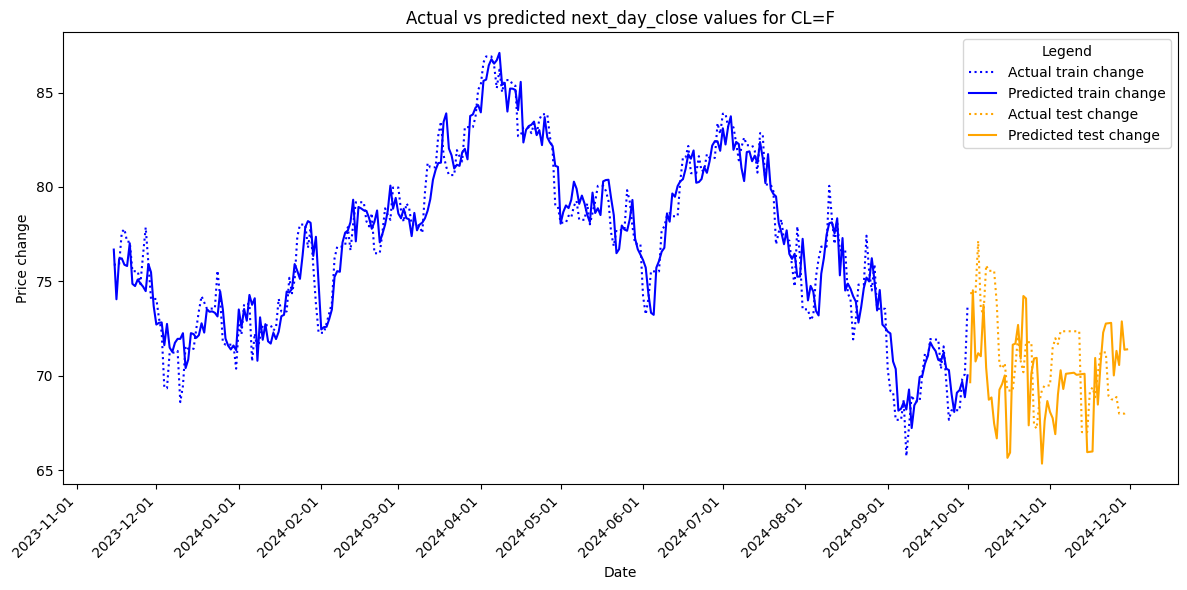

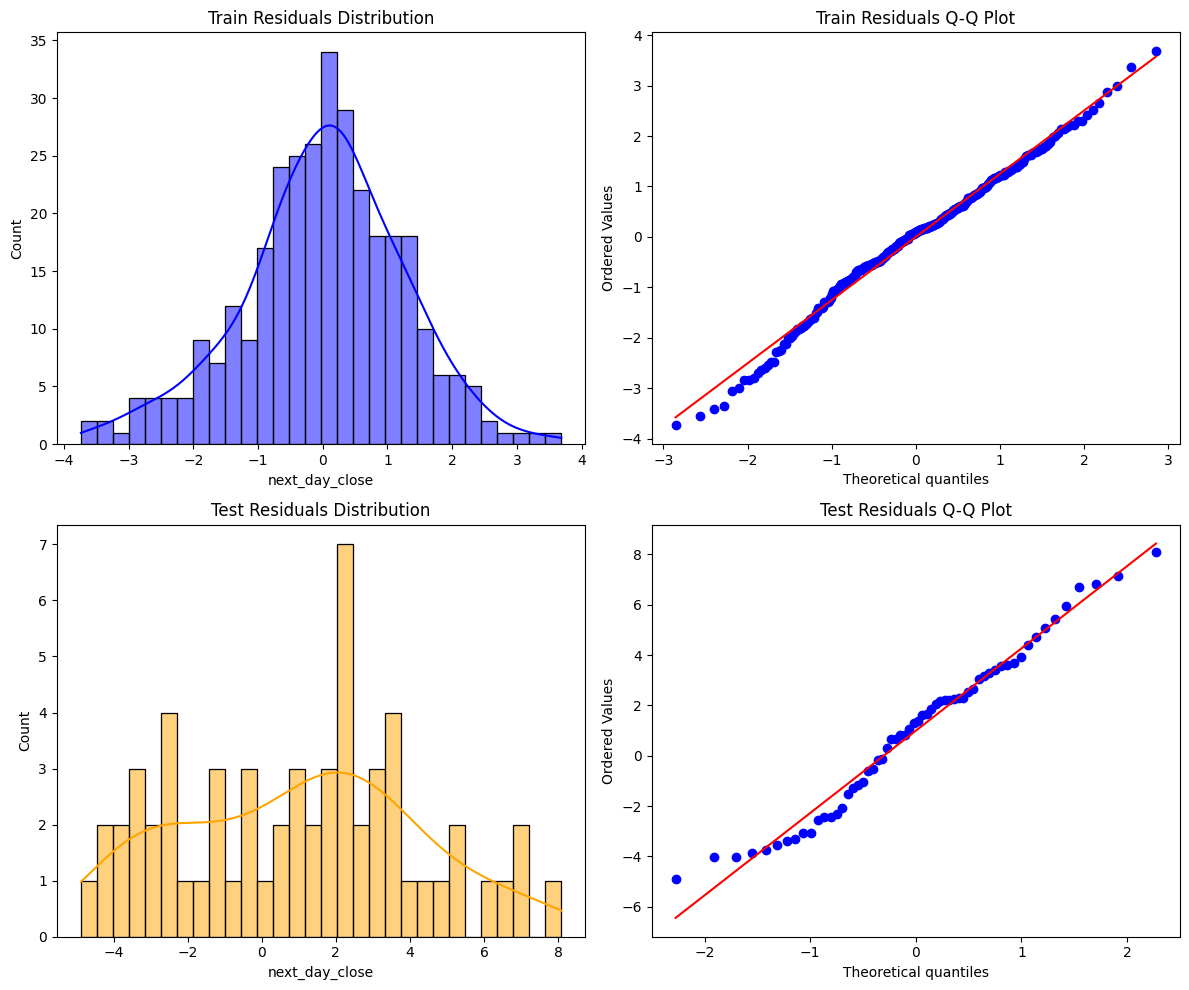

Shapiro-Wilk Test for Train Residuals: Statistic=0.9910, p-value=0.0467
Shapiro-Wilk Test for Test Residuals: Statistic=0.9734, p-value=0.2126


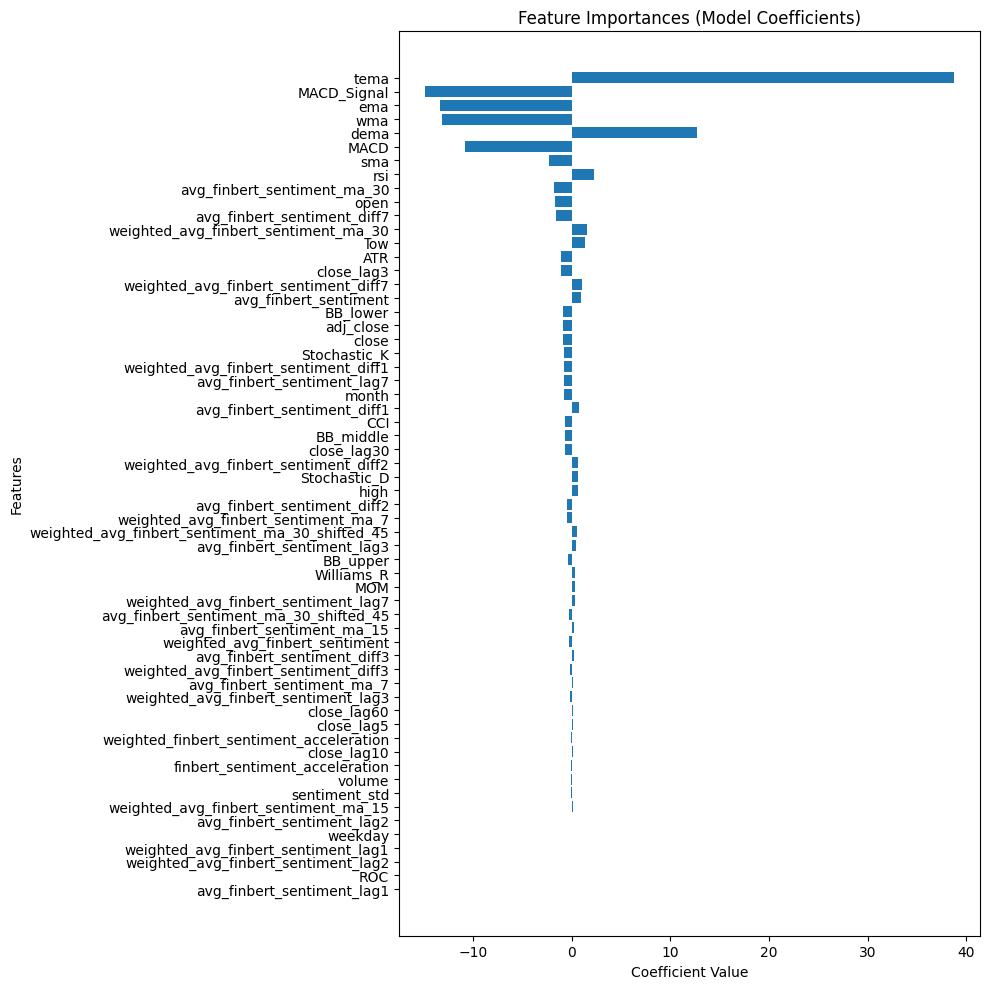

In [8]:
# устанавливаем  целевую переменную, тикер, горизонт для тестирования и признаки, которые надо удалить перед обучением
target = 'next_day_close'
ticker = 'CL=F'
test_len = 60
to_delete = ['price_change','next_day_close']

model = LinearRegression()
shift_days = 2 # количество дней вперед, на которое будем предсказывать цену

model, scaler, chosen_features = run_model(target, ticker, test_len, to_delete, model, shift_days,all_combinations)

После обучения модели линейной регрессии мы видим, что на тренировочной части у нас высокая точность, однако на тестовой уже появляются значительные отклонения. MAPE на тесте в 3 раза выше, MSE выше в 10 раз. Визуально иакже наблюдаются сильные отклонения. Анализ остатков показывает, что на тренировочной части данные распределены очень близко к нормальному распределению, и также QQplot показывает, что отклонения от теоретического распределения небольшие, но судя по тесту Shapiro-Wilk необходимо отвергнуть гипотезу о нормальности распределения. На тестовой части распределение имеет намного меньше общего с нормальным при визуальной оценке, QQplot показывает более выраженные отклонения, однако тест Shapiro-Wilk показывает, что мы не можем отвергнуть гипотезу о нормальности распределения. Здесь необходимо сделать поправку на объем данных, в тренировочной части их значительно больше и тест может с большей чувствительностью найти отклонения. 

Важность признаков распределена следующим образом. У нас есть несколько признаков с большим весом: tema, dema, wma, MACD_Signal, ema, MACD. Все остальные признаки имеют значительно меньший вес.
Для более ясной оценки попробуем провести обучение Ridge модели, чтобы посмотреть, как изменятся веса признаков. 

А также на графике видно, что предсказанный временной ряд практически повторяет фактический временной ряд с небольшим смещением на два дня вперед. Это, вероятно, связано с тем, что в данных присутствуют значительные колебания на длинном горизонте, и модель преимущественно ориентируется на ближайшие известные значения, чтобы минимизировать ошибку. В результате модель фактически ‘сдвигает’ последние известные данные на прогнозируемый горизонт, вместо того чтобы учитывать более сложные зависимости и тренды. 

Для того, чтобы избавиться от этой проблемы, попробуем предсказать отклонение целевой переменной от последней известной точки цены и восстановить исходный временной ряд, просуммировав исторические данные с их отклонениями.

Train MAPE: 449011698698533.5625
Test MAPE: 1975314825630490.2500
Train MSE: 1.6240
Test MSE: 8.2646


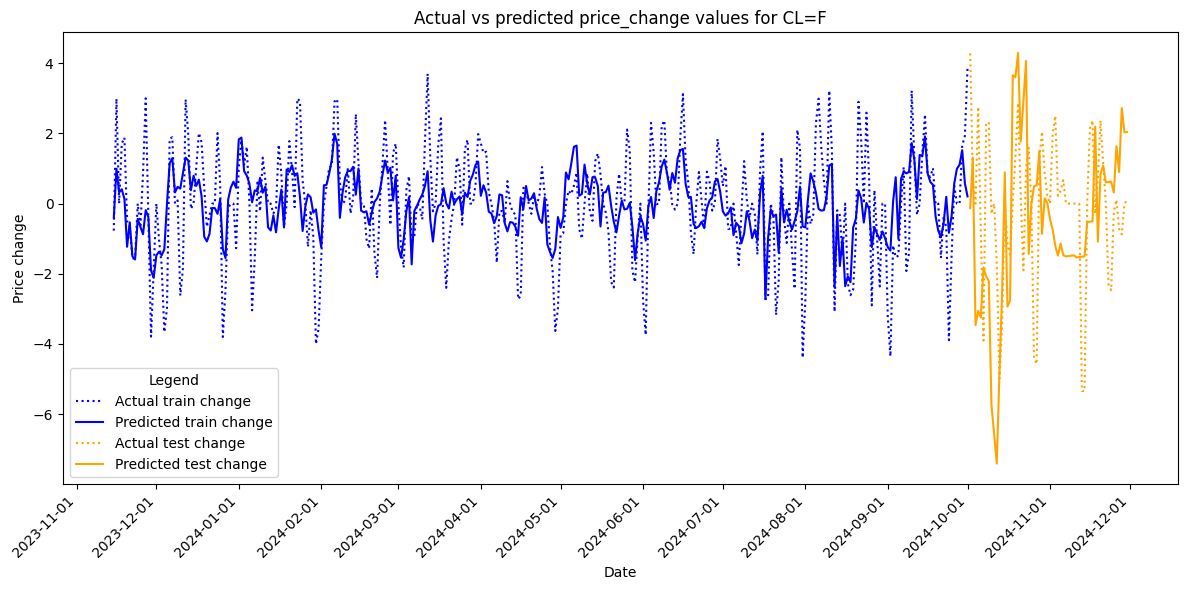

Restored train MAPE: 0.0129
Restored test MAPE: 0.0334
Restored train MSE: 1.6240
Restored test MSE: 8.2646


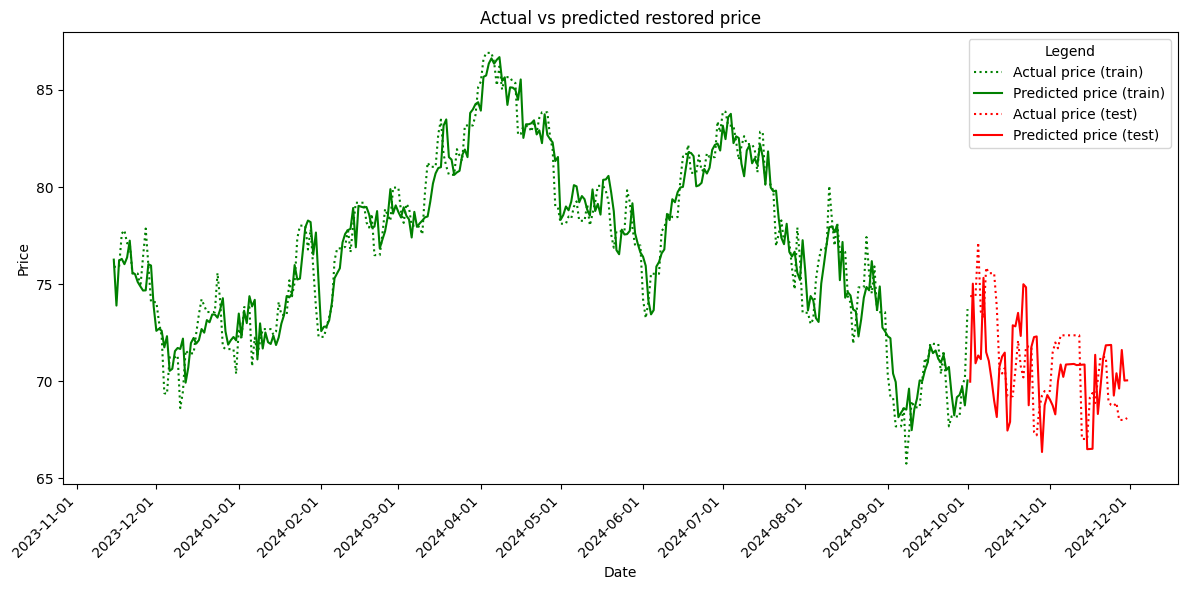

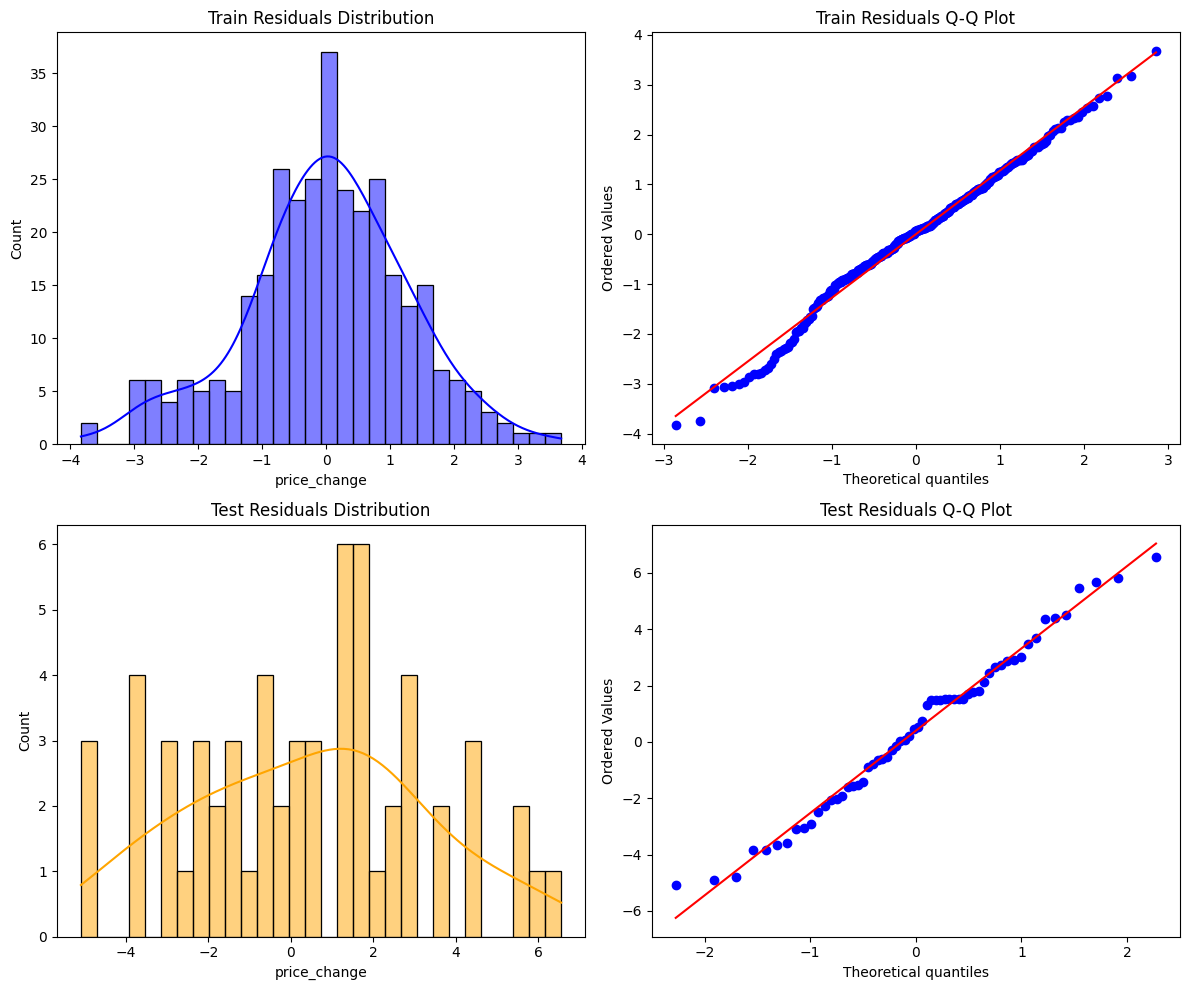

Shapiro-Wilk Test for Train Residuals: Statistic=0.9904, p-value=0.0328
Shapiro-Wilk Test for Test Residuals: Statistic=0.9824, p-value=0.5389


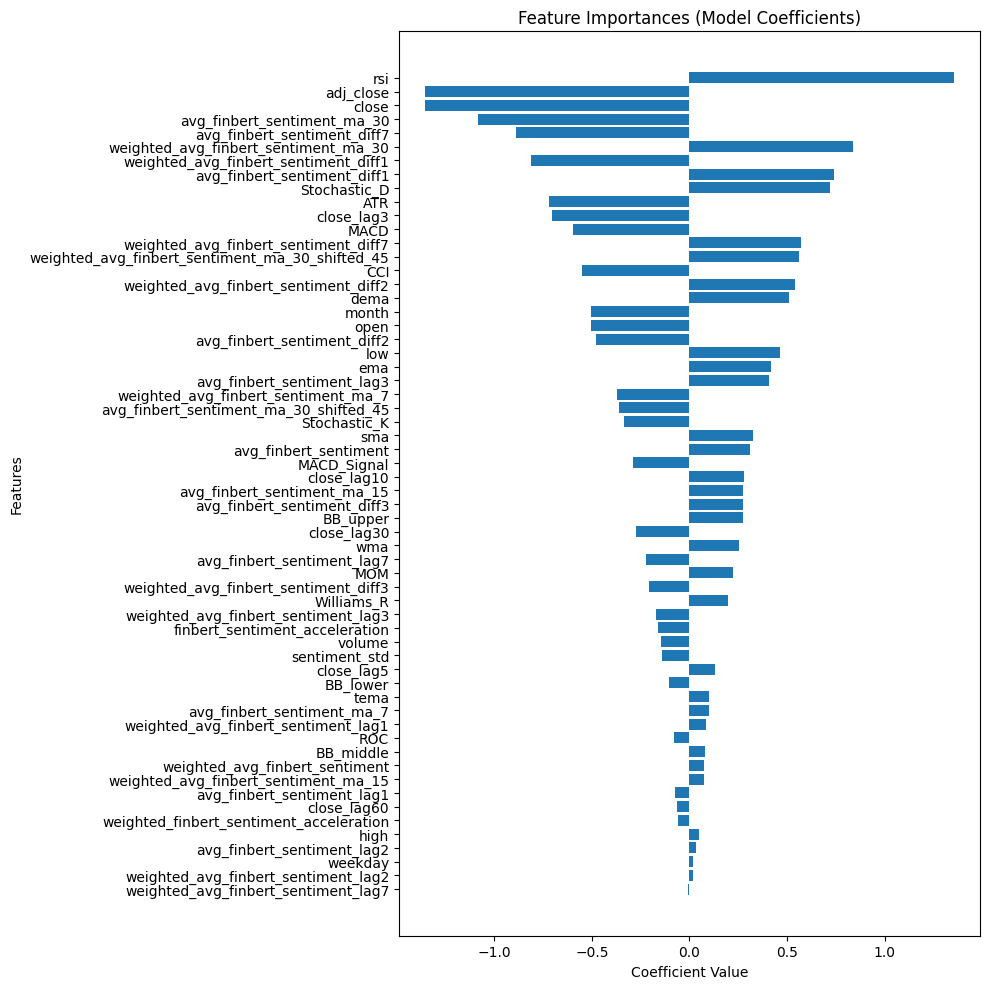

In [9]:

target = 'price_change'
ticker = 'CL=F'
test_len = 60
to_delete = ['price_change','next_day_close']

model = Ridge()
shift_days = 2

model, scaler, chosen_features = run_model(target, ticker, test_len, to_delete, model, shift_days,all_combinations)

Все еще наблюдается большая разница ошибки трейна и теста по метрике MSE, и на тесте мы видим куда более значительные колебания, все еще есть предположение переобучения модели.

К тому же мы видим, что на графике разниц цен присутсвует сильная амплитуда, в то время как прогнозные значения значительно более сглаженные. По всей видимости либо у нас недостаточно данных чтобы модель могла объяснить дисперсию разниц цен, либо это слшиком сложные для линейной модели. Также возможно, что высокая волотильность частично обусловлена шумом. Так как прогноз разниц часто находится около нуля, то сумма последней известной цены + прогноз разницы примерно равны последнему значению цены.  Эта проблема видится наиболее серьезной, так как, несмотря на высокую точность, **модель не является валидной**.

Для того, чтобы избавиться от этой проблемы, попробуем предсказывать на 20 дней вперед. Тогда корреляция с последним известным значением будет значительно ниже, что не позволит модели цепляться за эти связи, а разницы цен будут менее волатильными, т.к. на длительном горизонте увеличивается влияние факторов с длительным эффектом и мы будем уже предсказывать не столько шум, сколько настоящие изменения ряда.  

Начнем с прогноза разниц:


Train MAPE: 21380453402340.7500
Test MAPE: 3.3719
Train MSE: 3.3902
Test MSE: 27.9892


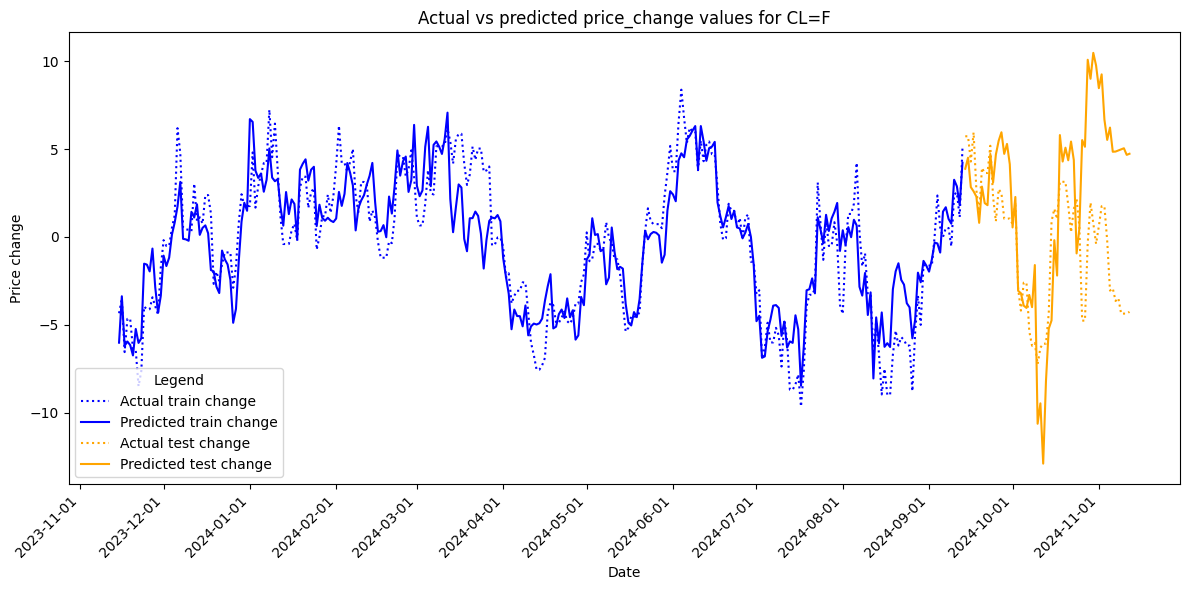

Restored train MAPE: 0.0188
Restored test MAPE: 0.0597
Restored train MSE: 3.3902
Restored test MSE: 27.9892


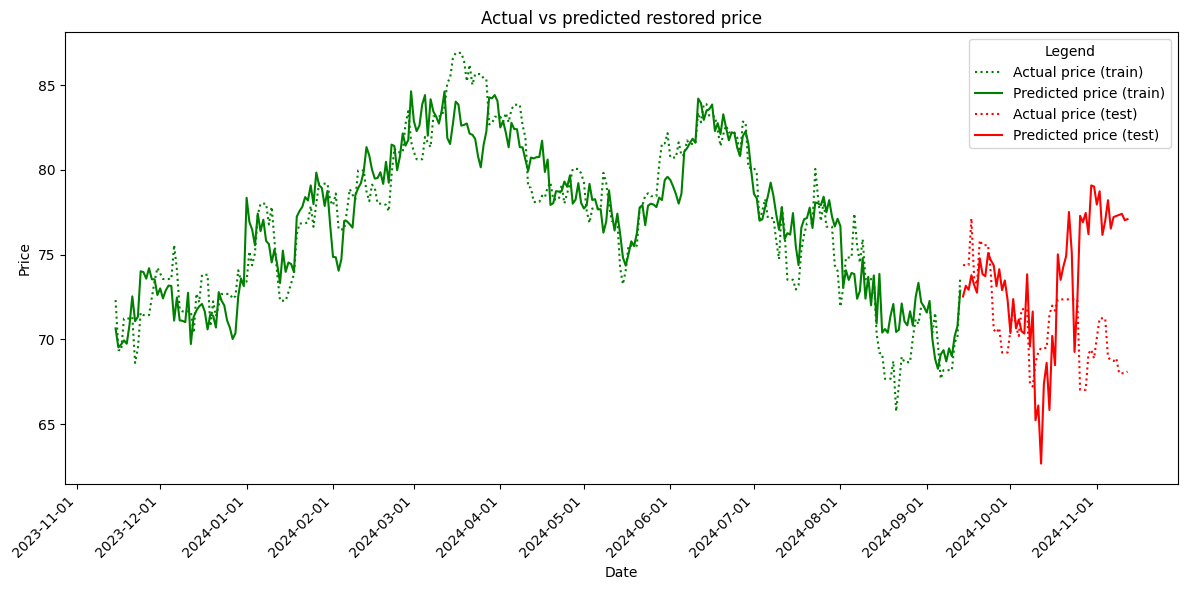

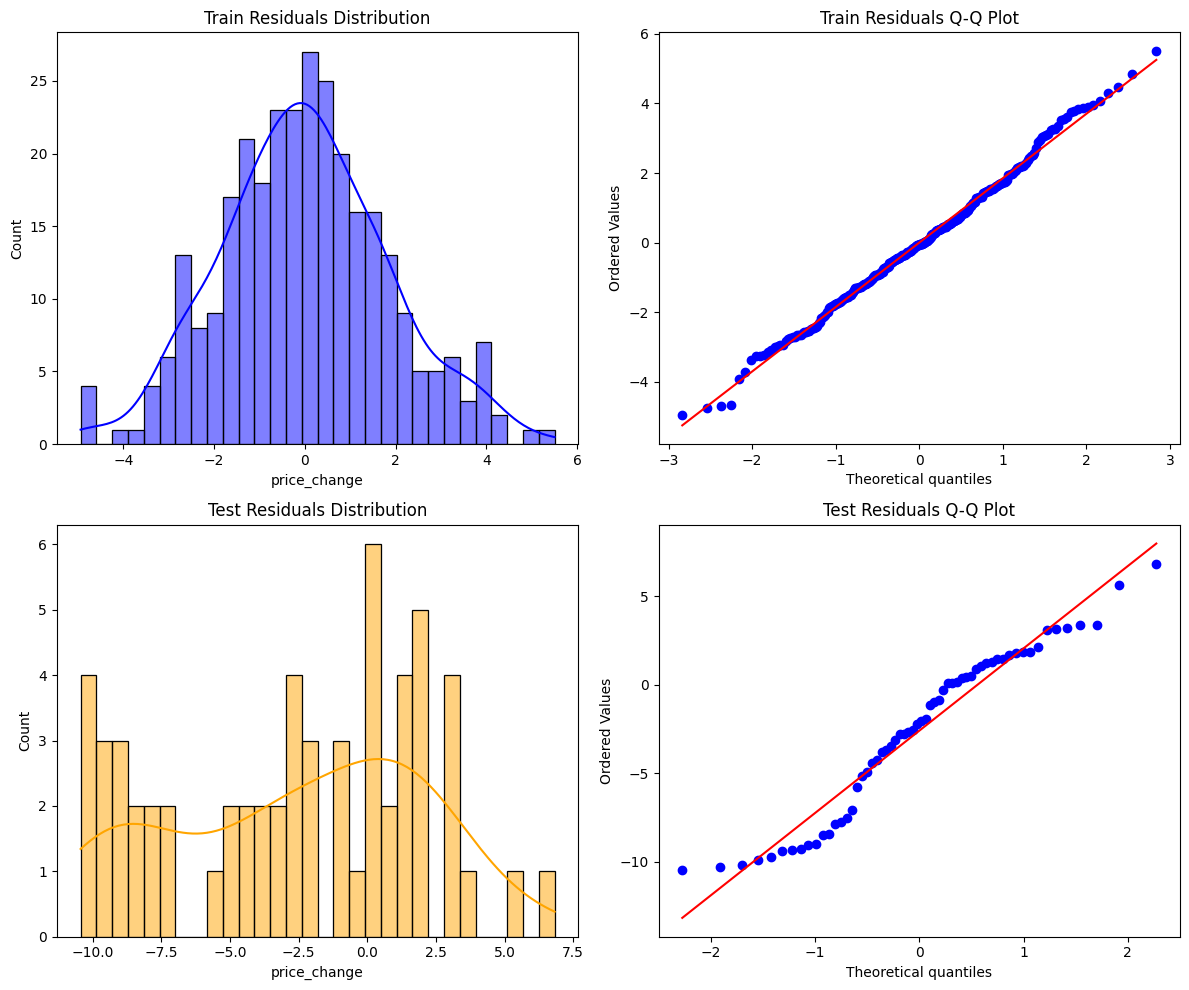

Shapiro-Wilk Test for Train Residuals: Statistic=0.9953, p-value=0.4886
Shapiro-Wilk Test for Test Residuals: Statistic=0.9438, p-value=0.0081


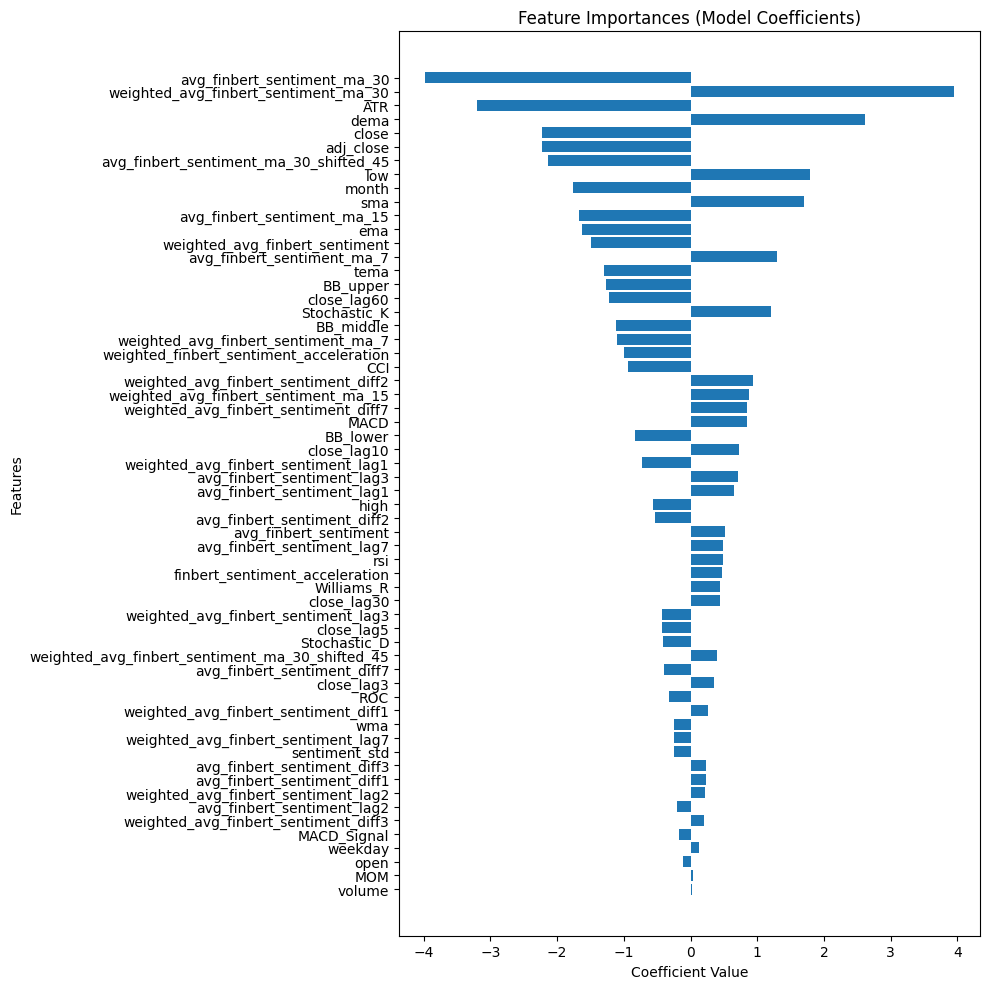

In [10]:
target = 'price_change'
ticker = 'CL=F'
test_len = 60
to_delete = ['price_change','next_day_close']

model = Ridge()
shift_days = 20

model, scaler, chosen_features = run_model(target, ticker, test_len, to_delete, model, shift_days,all_combinations)

 Итак, мы видим то, что волатильность разницы значительно сократилась, сами прогнозы стали более осмысленными, и восстановленный временной ряд с помощью сложения последнего известного значения с прогнозной разницей действительно показывает нам не просто смещенную линию факта, а полноценный прогноз. К тому же мы видим, что на первое место в списке признаков выходит сглаженное среднее сентимента за 30 дней, и аналогичный признак для взвешенного сентимента. Так как оба эти признака очень похожи и модель присвоила им веса с большими значениями и разными знаками, то, вероятно имеет место переобучение. На это также указывает резкий разрыв метрик MAPE и MSE на трейне и тесте при оценке фактической цены. К тому же остатки на тестовых данных имеют отличное от нормального распределение.
 
 Попробуем убрать признаки по сентиментам, которые не были взвешены на ранг источника и обучим модель на фактических ценах, а не разницах

Train MAPE: 0.0291
Test MAPE: 0.0294
Train MSE: 7.2452
Test MSE: 7.1571


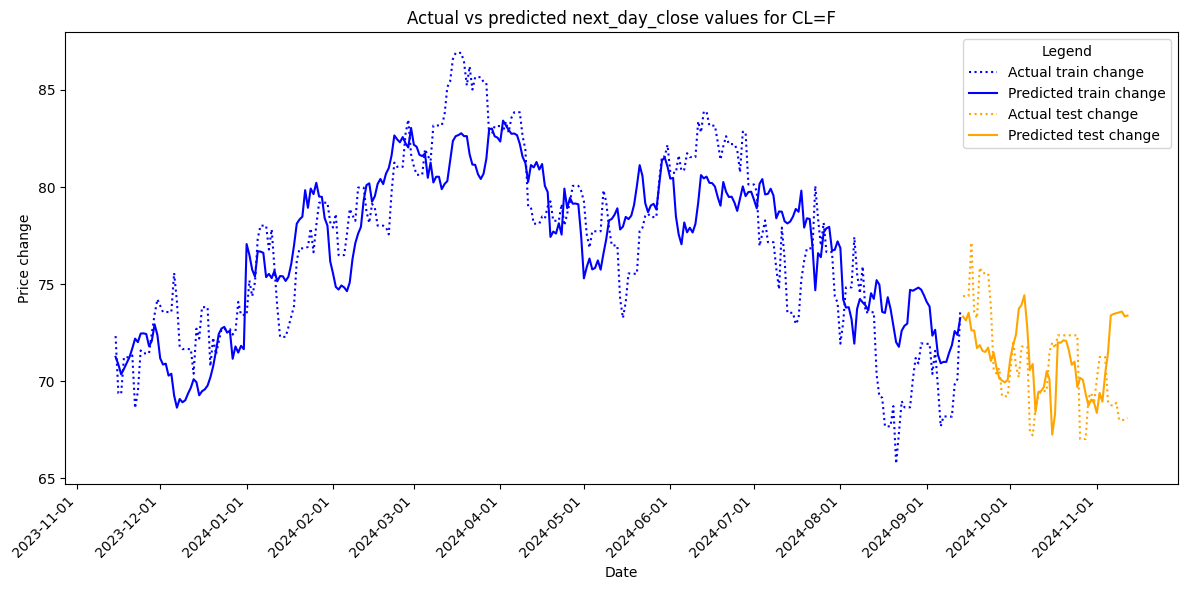

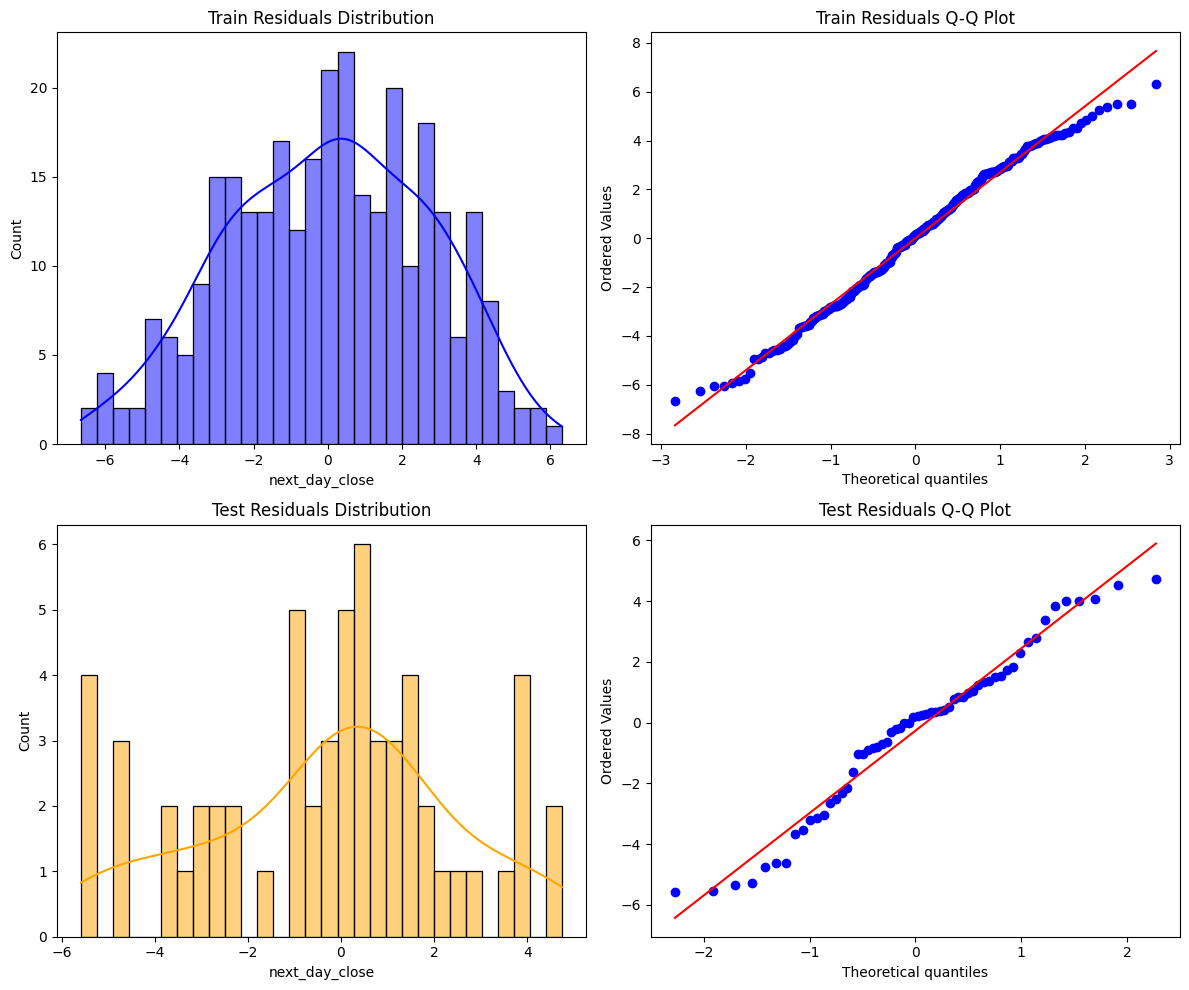

Shapiro-Wilk Test for Train Residuals: Statistic=0.9896, p-value=0.0285
Shapiro-Wilk Test for Test Residuals: Statistic=0.9653, p-value=0.0859


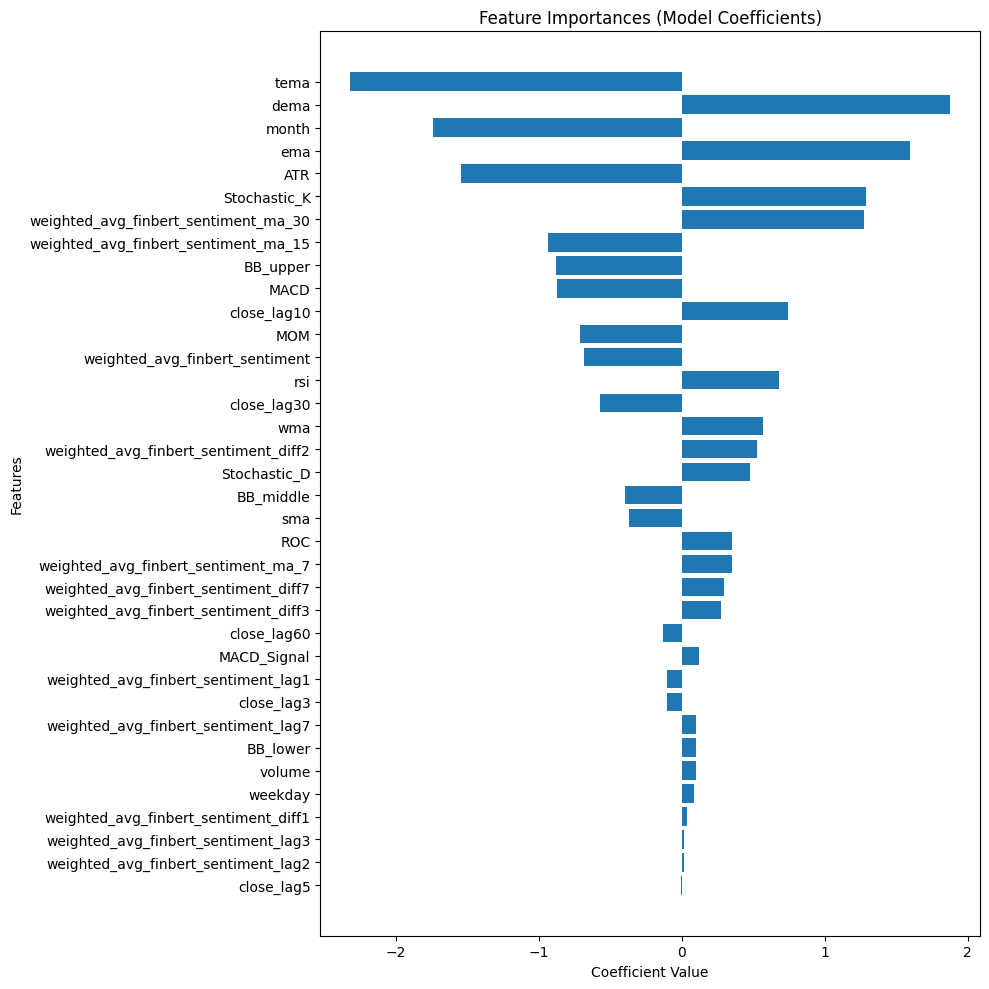

In [11]:
target = 'next_day_close'
ticker = 'CL=F'
test_len = 60
to_delete = [
    
# удаляем целевую переменную
    'price_change','next_day_close',
 
# удаляем прямой показатель последней известной цены
   'low','high','open','close', 'adj_close',
# удаляем признаки, которые ведут к переобучению, это установлено вручную, но причина не определена
  'CCI','Williams_R', 'weighted_avg_finbert_sentiment_ma_30_shifted_45', 'weighted_finbert_sentiment_acceleration',
 
# удаляем признаки, которые дублируют свои weighted_ аналоги
 'avg_finbert_sentiment',
 'sentiment_std',
 'avg_finbert_sentiment_lag1',
 'avg_finbert_sentiment_diff1',
 'avg_finbert_sentiment_lag2',
 'avg_finbert_sentiment_diff2',
 'avg_finbert_sentiment_lag3',
 'avg_finbert_sentiment_diff3',
 'avg_finbert_sentiment_lag7',
 'avg_finbert_sentiment_diff7',
 'finbert_sentiment_acceleration',
 'avg_finbert_sentiment_ma_7',
 'avg_finbert_sentiment_ma_15',
 'avg_finbert_sentiment_ma_30',
 'avg_finbert_sentiment_ma_30_shifted_45']

model = Ridge()
shift_days = 20

CL_F_model, CL_F_scaler, CL_F_chosen_features = run_model(target, ticker, test_len, to_delete, model, shift_days,all_combinations)

Как результат увеличилась ошибка на трейне, уменьшилась на тесте, теперь они практически равны. Форма распределения остатков в тесте больше похожа на нормальное, менее выраженные отклонения на QQplot'e, а Shapiro-Wilk больше не позволяет отклонить гипотезу о нормальности распределения. Однако остатки на тренировчной выборке распределены уже не так нормально.

В целом уже можем считать такую модель валидной, она точно указывает на наличие и направление колебаний цены,однако интенсивность этих колебаний может значительно отличаться. На бумаге точность хорошая - Test MAPE: 0.0294, но на графике наблюдаются периоды, в которых присутсвует значительная часть необъясненной моделью дисперсии. Остается под вопросом проблема или в высокой сложности  связей признаков, либо это недостаток качественно других признаков. В любом случае с линейной моделью и тем набором данных, что у нас есть мы исчерпали ресурс для дальнейших улучшений.

Проведем аналогичное обучение для тикера BZ=F:



Train MAPE: 0.0289
Test MAPE: 0.0256
Train MSE: 7.7462
Test MSE: 6.2791


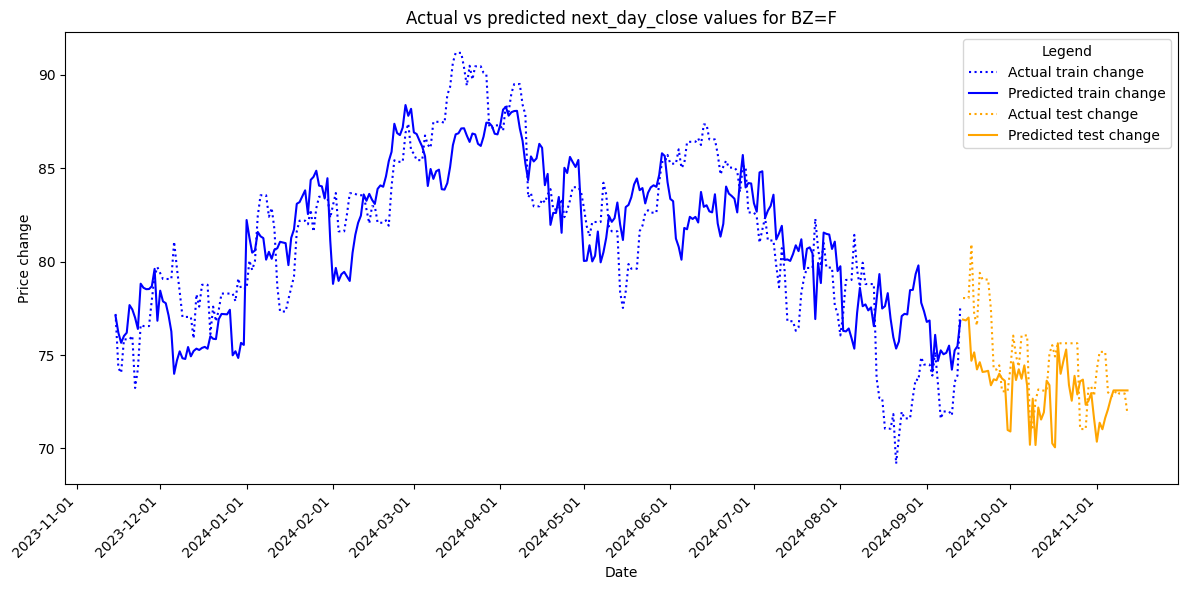

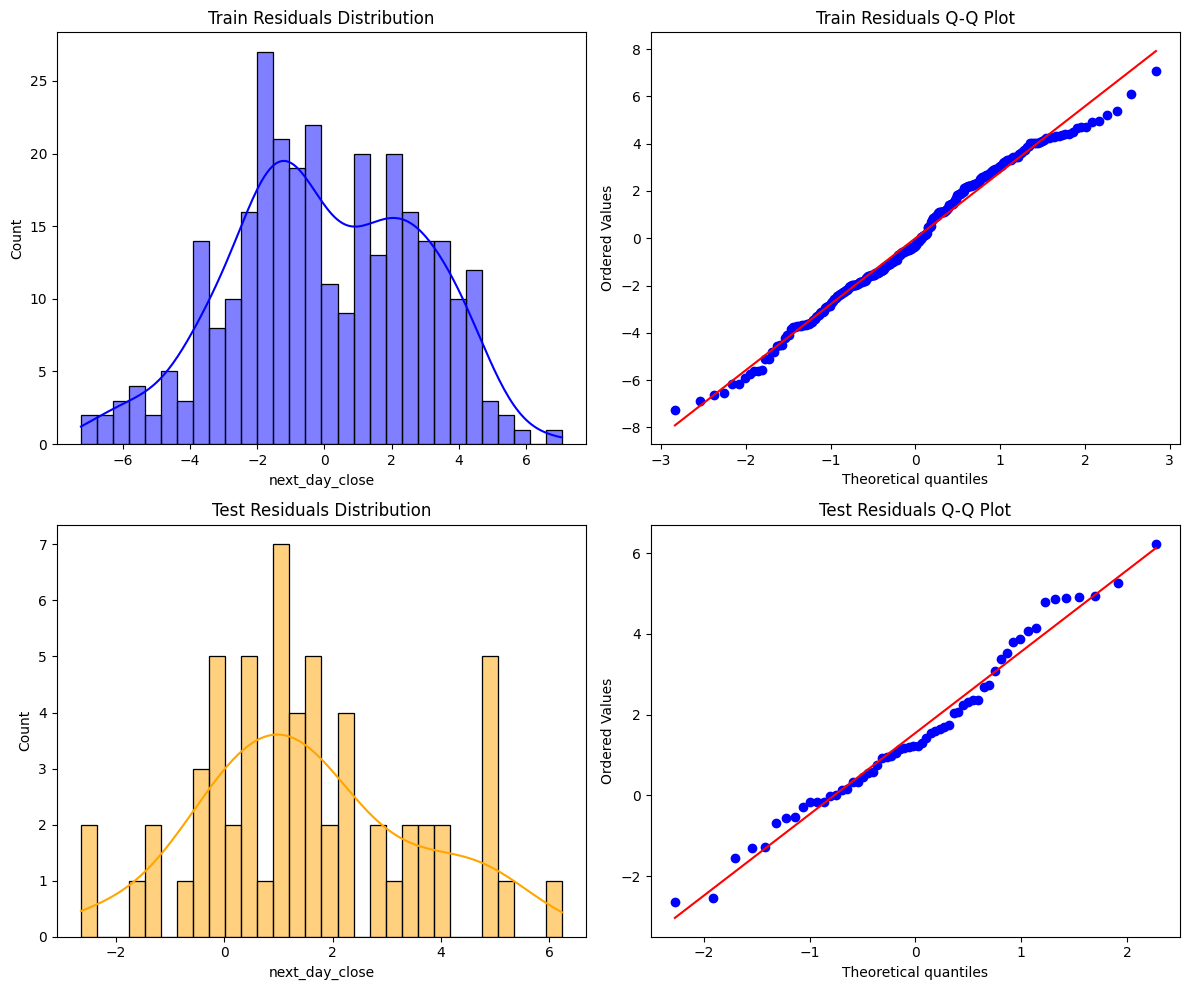

Shapiro-Wilk Test for Train Residuals: Statistic=0.9876, p-value=0.0104
Shapiro-Wilk Test for Test Residuals: Statistic=0.9766, p-value=0.3025


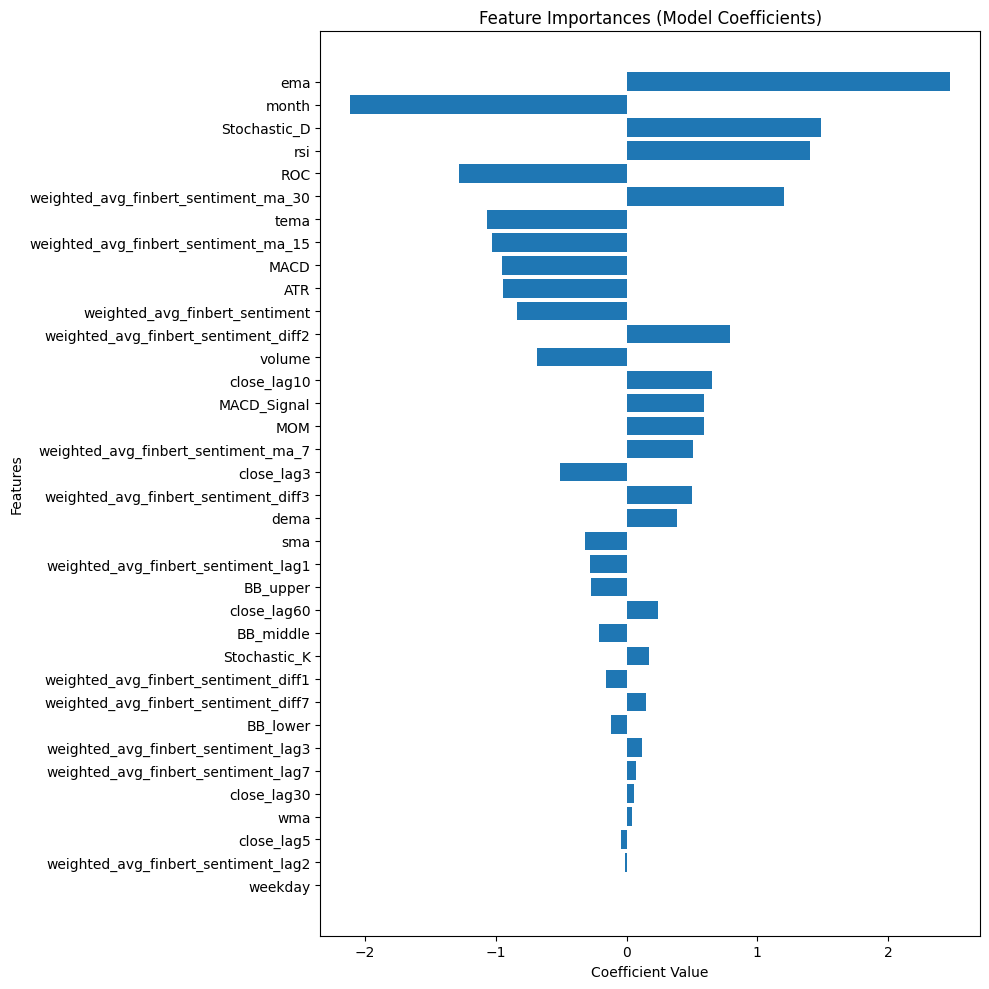

In [12]:
target = 'next_day_close'
ticker = 'BZ=F'
test_len = 60
to_delete = [
    
# удаляем целевую переменную
    'price_change','next_day_close',
 
# удаляем прямой показатель последней известной цены
   'low','high','open','close', 'adj_close',
# удаляем признаки, которые ведут к переобучению, это установлено вручную, но причина не определена
  'CCI','Williams_R', 'weighted_avg_finbert_sentiment_ma_30_shifted_45', 'weighted_finbert_sentiment_acceleration',
 
# удаляем признаки, которые дублируют свои weighted_ аналоги
 'avg_finbert_sentiment',
 'sentiment_std',
 'avg_finbert_sentiment_lag1',
 'avg_finbert_sentiment_diff1',
 'avg_finbert_sentiment_lag2',
 'avg_finbert_sentiment_diff2',
 'avg_finbert_sentiment_lag3',
 'avg_finbert_sentiment_diff3',
 'avg_finbert_sentiment_lag7',
 'avg_finbert_sentiment_diff7',
 'finbert_sentiment_acceleration',
 'avg_finbert_sentiment_ma_7',
 'avg_finbert_sentiment_ma_15',
 'avg_finbert_sentiment_ma_30',
 'avg_finbert_sentiment_ma_30_shifted_45']

model = Ridge()
shift_days = 20

BZ_F_model, BZ_F_scaler, BZ_F_chosen_features = run_model(target, ticker, test_len, to_delete, model, shift_days,all_combinations)

Очень похожая ситуация, в целом модель обучилась корректно, однако все еще наблюдаются некоторые значительные смещения в прогнозах.

### Часть 2. Тикеры SPY и QQQ
Теперь аналогичным образом проверим для двух оставшихся тикеров. Сначала посмотрим на прогноз отклонения цены и востановленную итоговую цену.

Train MAPE: 1.5523
Test MAPE: 1.5644
Train MSE: 85.5225
Test MSE: 302.8055


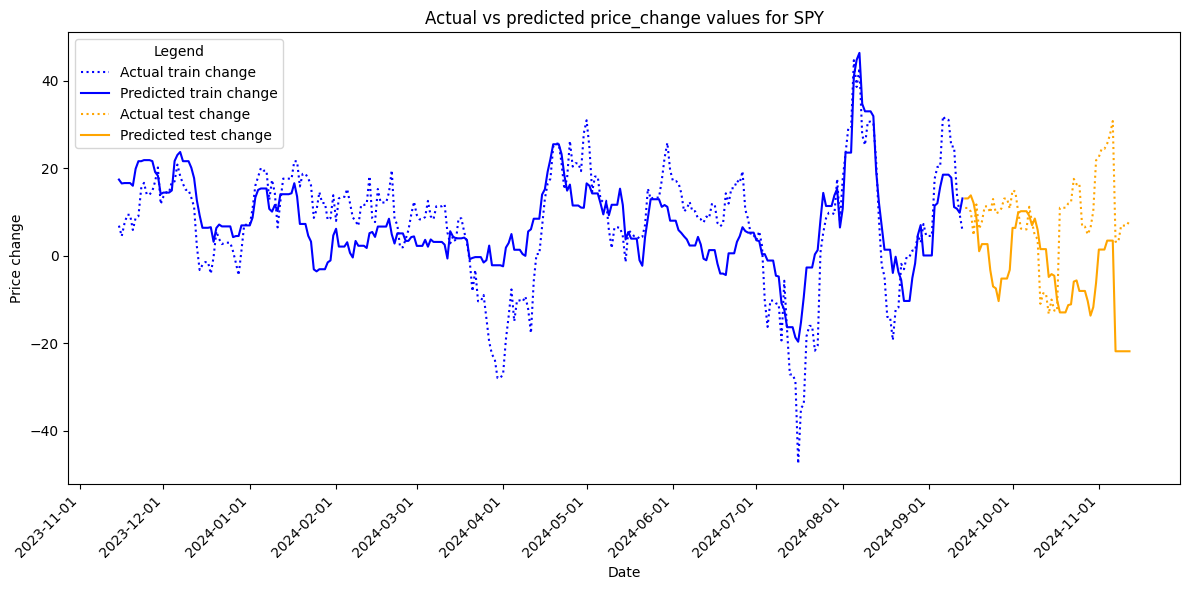

Restored train MAPE: 0.0144
Restored test MAPE: 0.0251
Restored train MSE: 85.5225
Restored test MSE: 302.8055


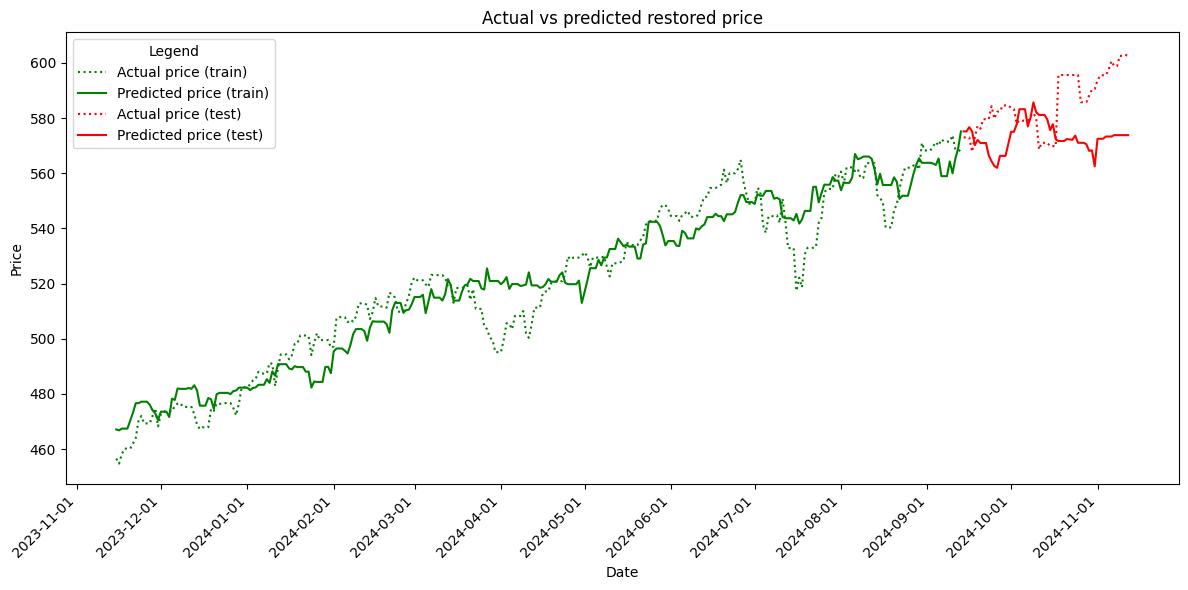

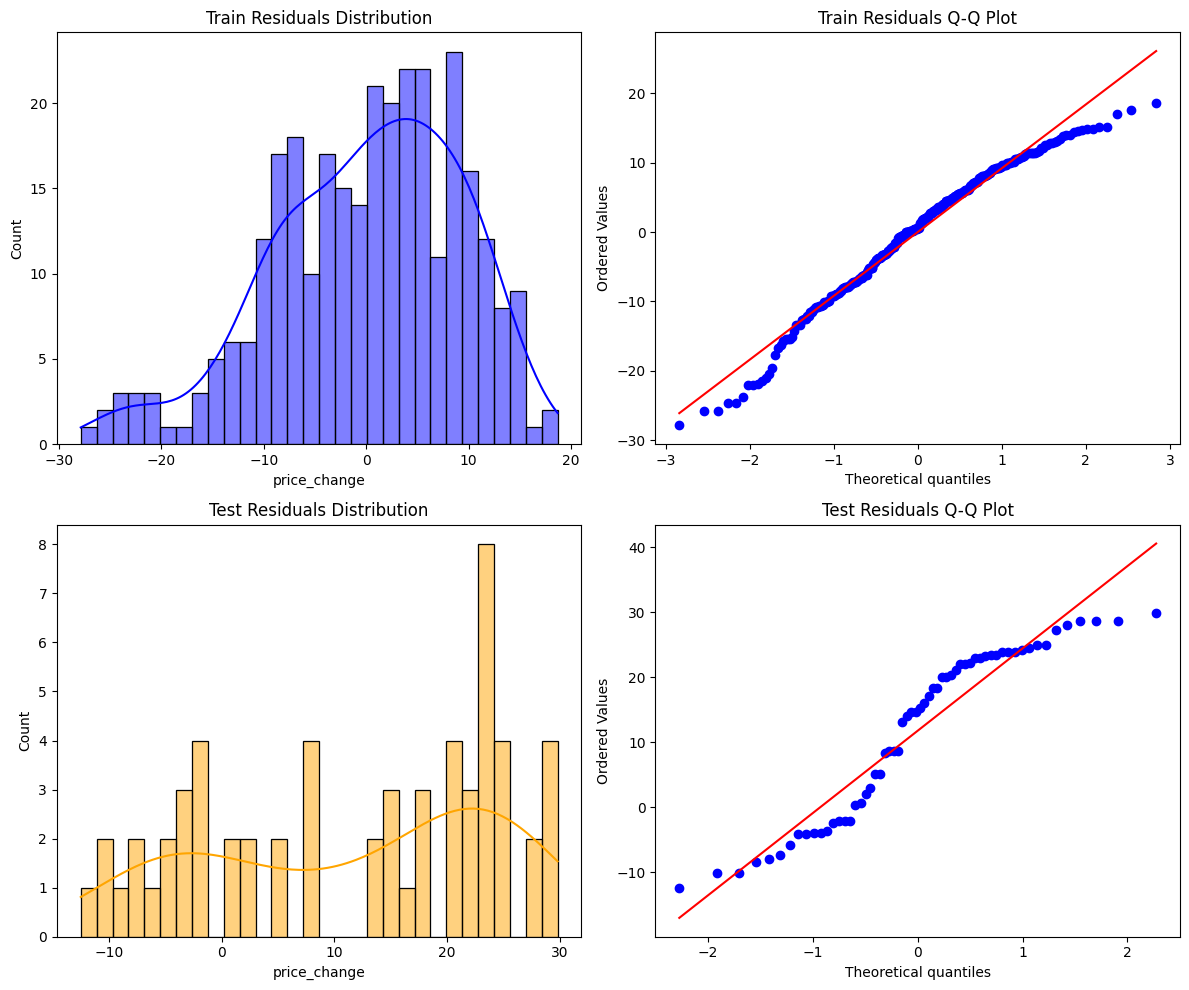

Shapiro-Wilk Test for Train Residuals: Statistic=0.9736, p-value=0.0000
Shapiro-Wilk Test for Test Residuals: Statistic=0.9060, p-value=0.0002


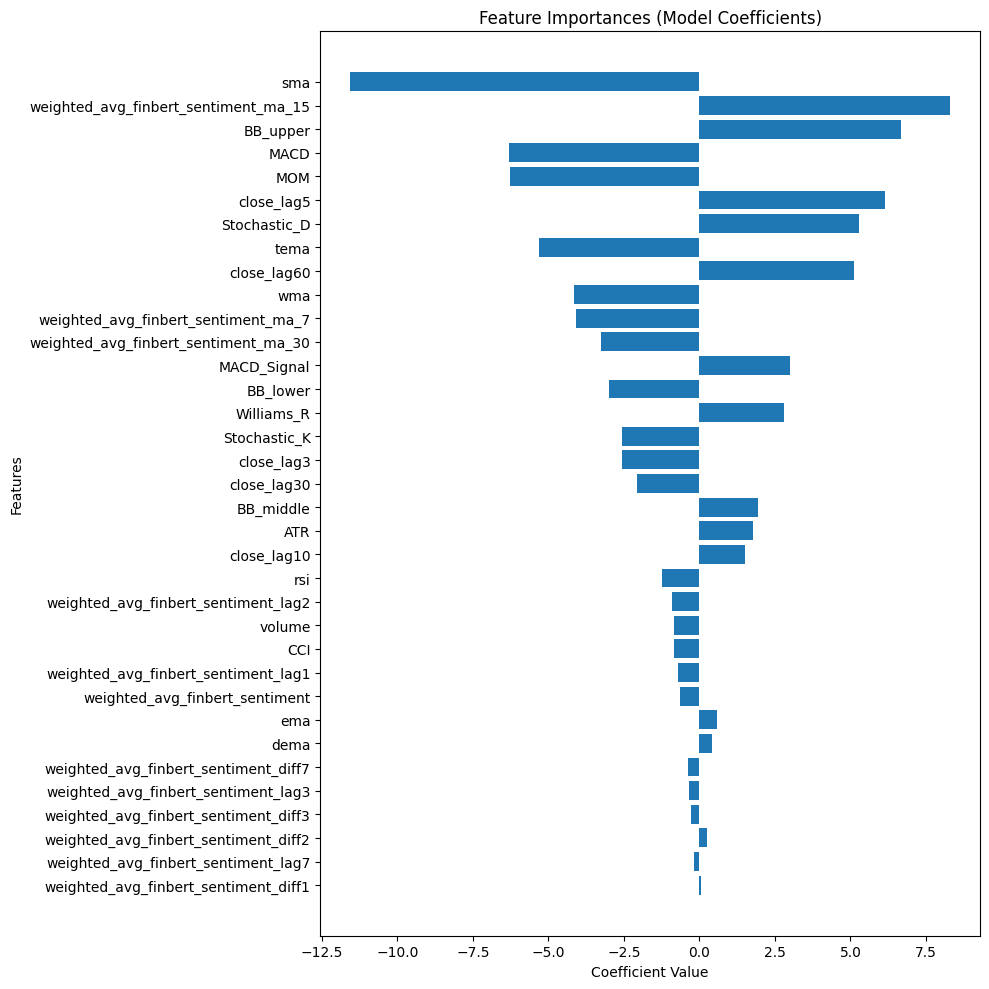

Train MAPE: 211590712032768.7812
Test MAPE: 6.8658
Train MSE: 116.1977
Test MSE: 532.6720


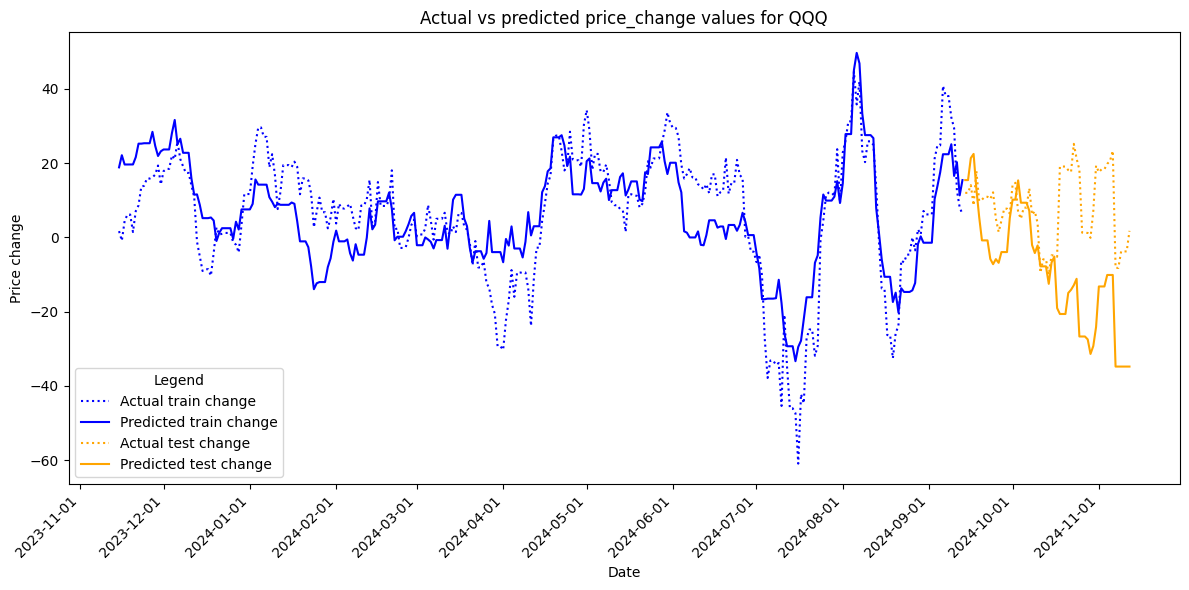

Restored train MAPE: 0.0198
Restored test MAPE: 0.0365
Restored train MSE: 116.1977
Restored test MSE: 532.6720


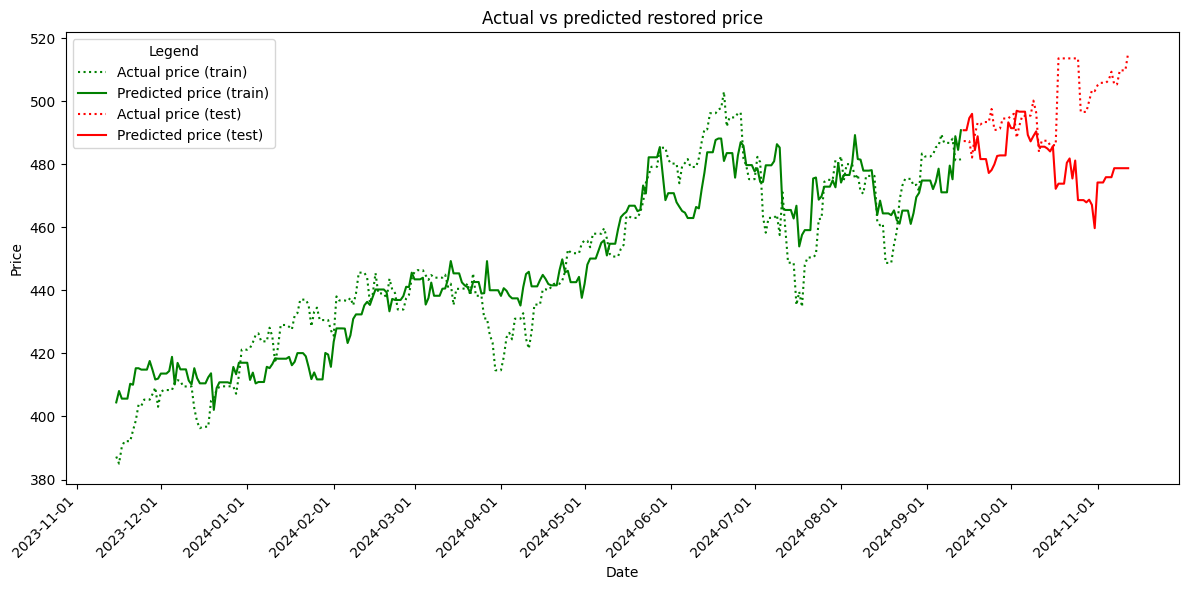

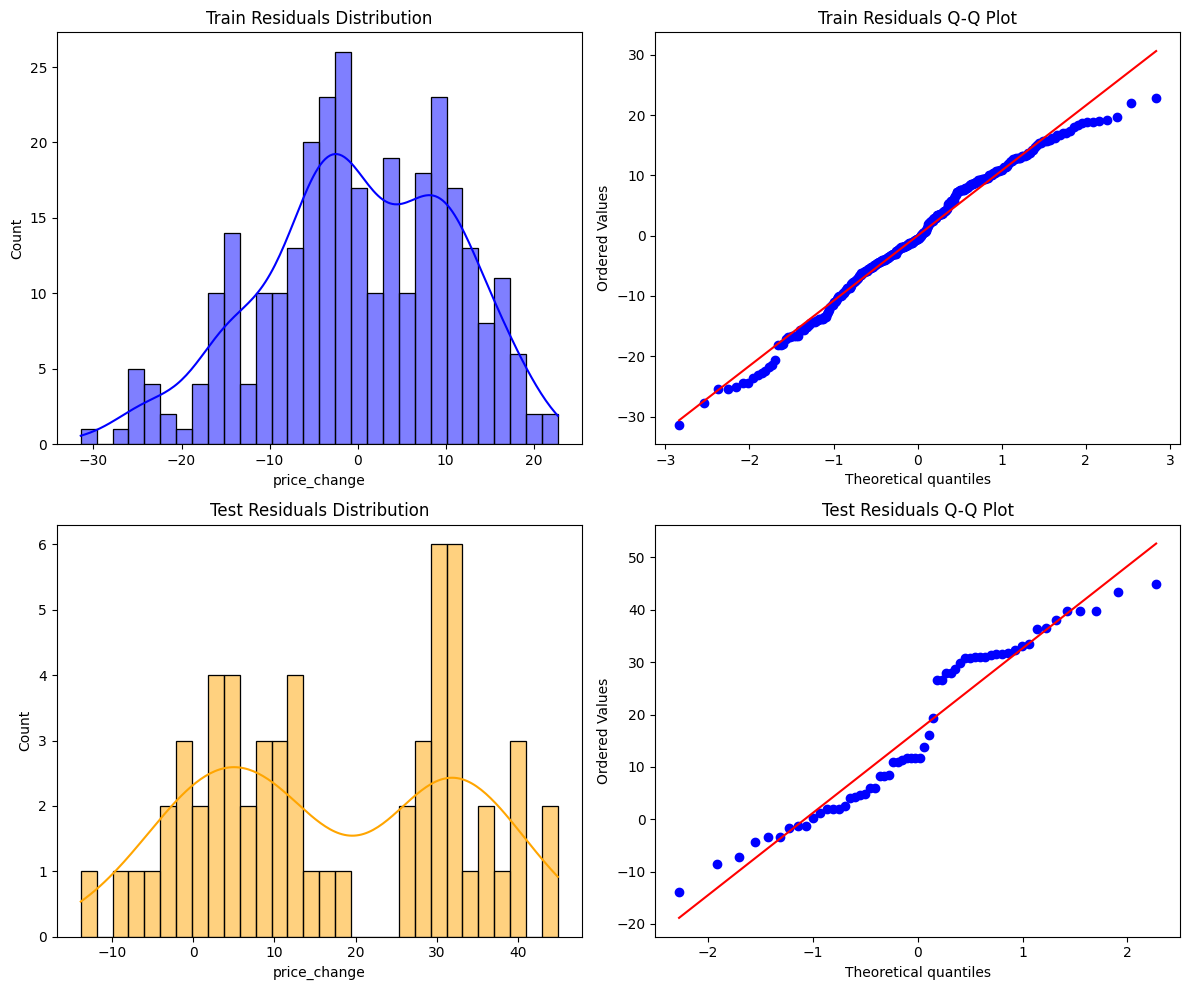

Shapiro-Wilk Test for Train Residuals: Statistic=0.9846, p-value=0.0024
Shapiro-Wilk Test for Test Residuals: Statistic=0.9318, p-value=0.0024


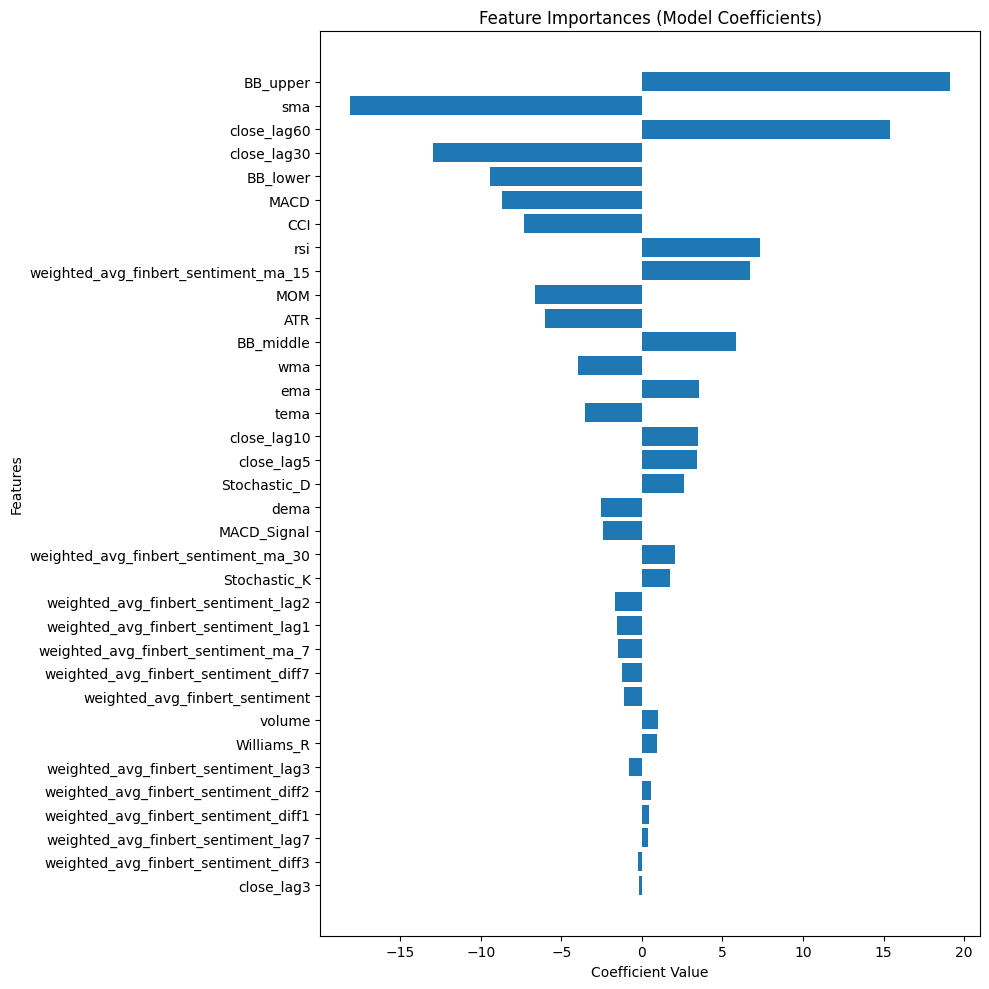

In [13]:

tickers = ['CL=F', 'BZ=F', 'SPY', 'QQQ']
target = 'price_change'
ticker = 'SPY'
test_len = 60
    
to_delete = [
    
# удаляем целевую переменную
    'price_change','next_day_close',

# удаляем прямой показатель последней известной цены
   'low','high','open','close', 'adj_close',

# удаляем признаки, которые ведут к переобучению, это установлено вручную, но причина не определена 
'weighted_avg_finbert_sentiment_ma_30_shifted_45', 'weighted_finbert_sentiment_acceleration','ROC',  'weekday', 'month',
    
# удаляем признаки, которые дублируют свои weighted_ аналоги
 'avg_finbert_sentiment',
 'sentiment_std',
 'avg_finbert_sentiment_lag1',
 'avg_finbert_sentiment_diff1',
 'avg_finbert_sentiment_lag2',
 'avg_finbert_sentiment_diff2',
 'avg_finbert_sentiment_lag3',
 'avg_finbert_sentiment_diff3',
 'avg_finbert_sentiment_lag7',
 'avg_finbert_sentiment_diff7',
 'finbert_sentiment_acceleration',
 'avg_finbert_sentiment_ma_7',
 'avg_finbert_sentiment_ma_15',
 'avg_finbert_sentiment_ma_30',
 'avg_finbert_sentiment_ma_30_shifted_45'
]

model = Ridge()
shift_days = 20

SPY_model, SPY_scaler, SPY_chosen_features = run_model(target, 'SPY', test_len, to_delete, model, shift_days,all_combinations)
QQQ_model, QQQ_scaler, QQQ_chosen_features = run_model(target, 'QQQ', test_len, to_delete, model, shift_days,all_combinations)

Для каждого из тикеров мы видим то, что модель уловила общую концепцию того, как цена колеблется, однако наблюдается серьезное смещение в тестовой части, где после резкого падения не происходит такого же большого подъема, как это было в случае с реальными данными. И на трейне, и на тесте остатки не распределены нормально. Видны серьезные смещения и на QQplot, и на гистограмме, и также по результатам теста Shapiro Wilk. Попробуем обучить модель Lasso, чтобы оставить только самые важные признаки. И проверим, как в данном случае ведет себя модель. Все так же на предсказании отклонений цены.


Train MAPE: 1.2126
Test MAPE: 1.3798
Train MSE: 96.0482
Test MSE: 242.6342


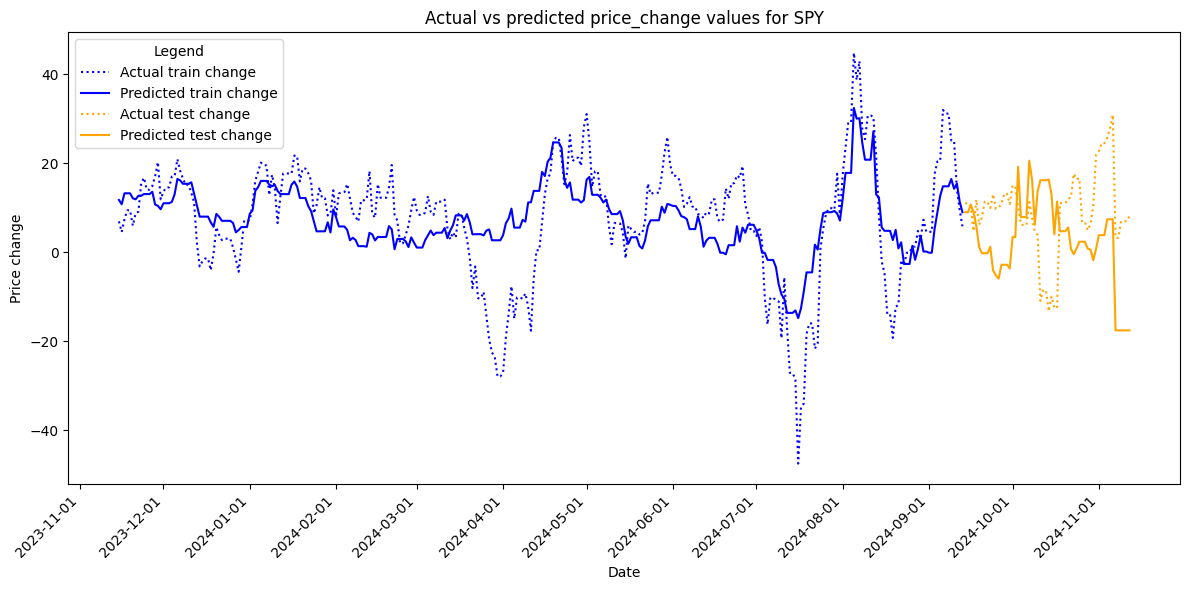

Restored train MAPE: 0.0145
Restored test MAPE: 0.0228
Restored train MSE: 96.0482
Restored test MSE: 242.6342


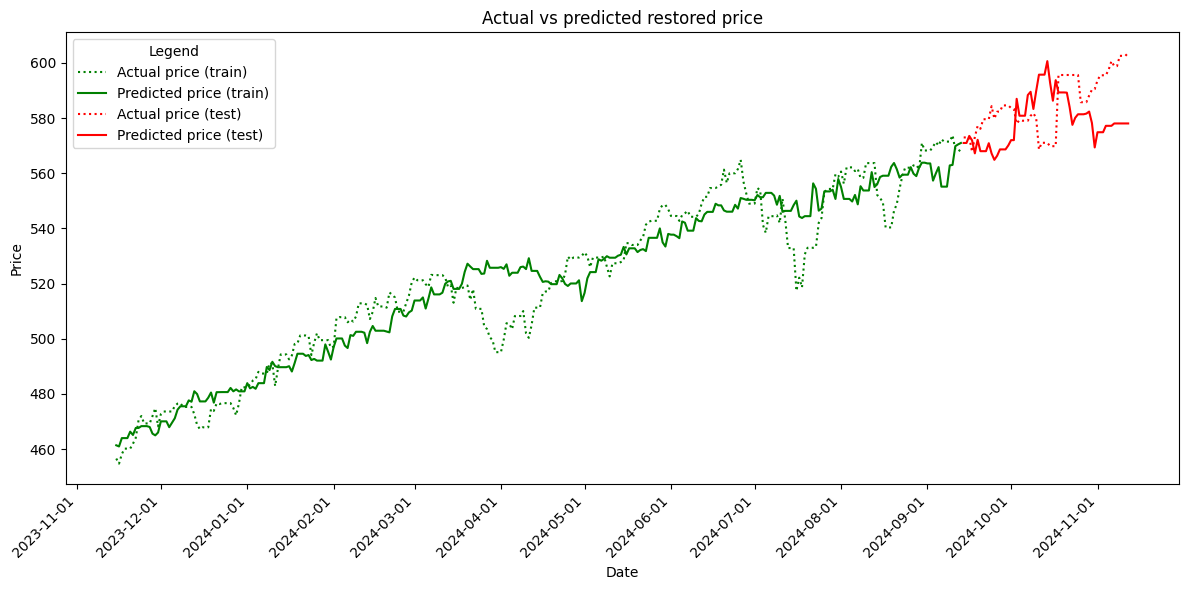

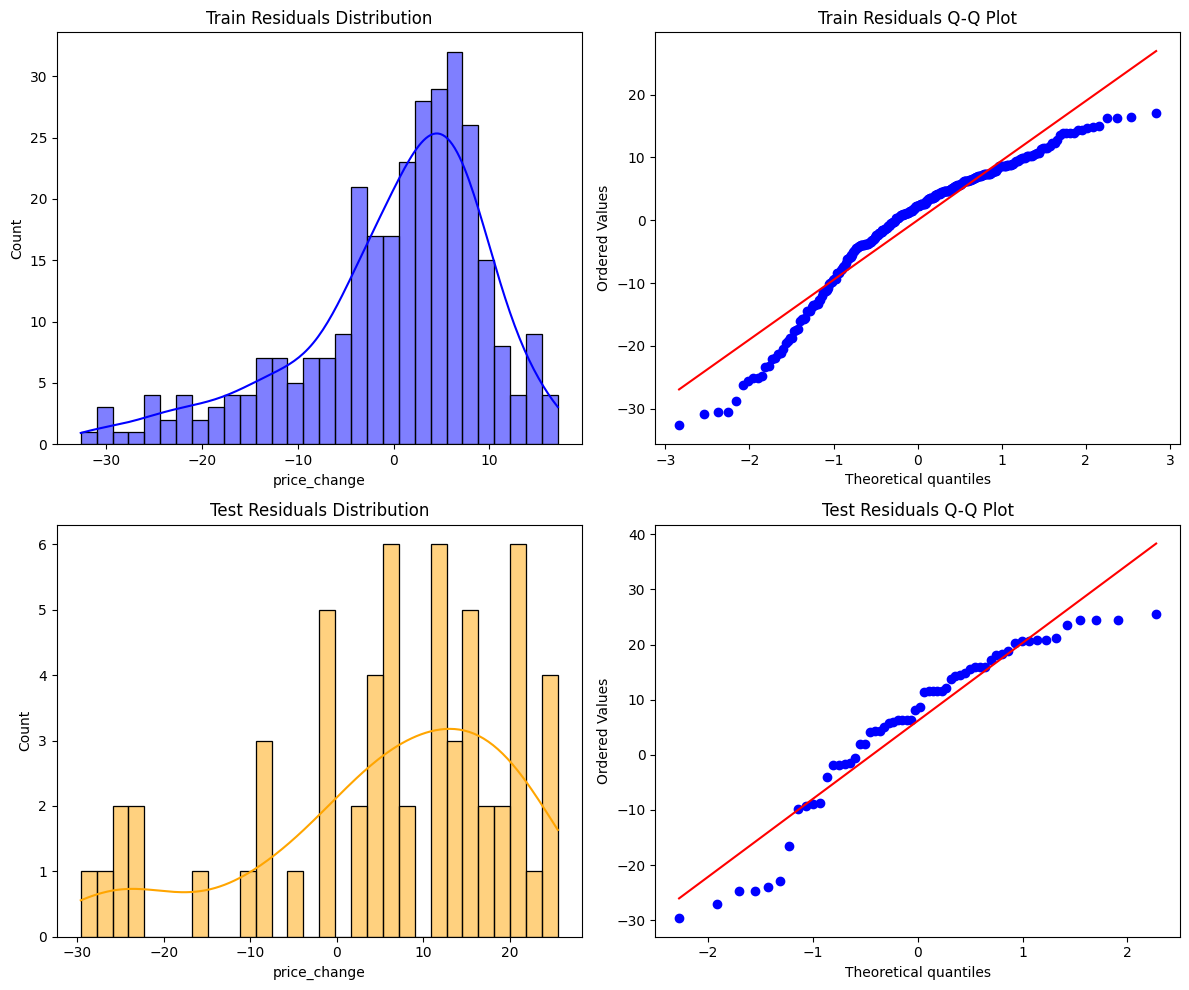

Shapiro-Wilk Test for Train Residuals: Statistic=0.9243, p-value=0.0000
Shapiro-Wilk Test for Test Residuals: Statistic=0.9115, p-value=0.0004


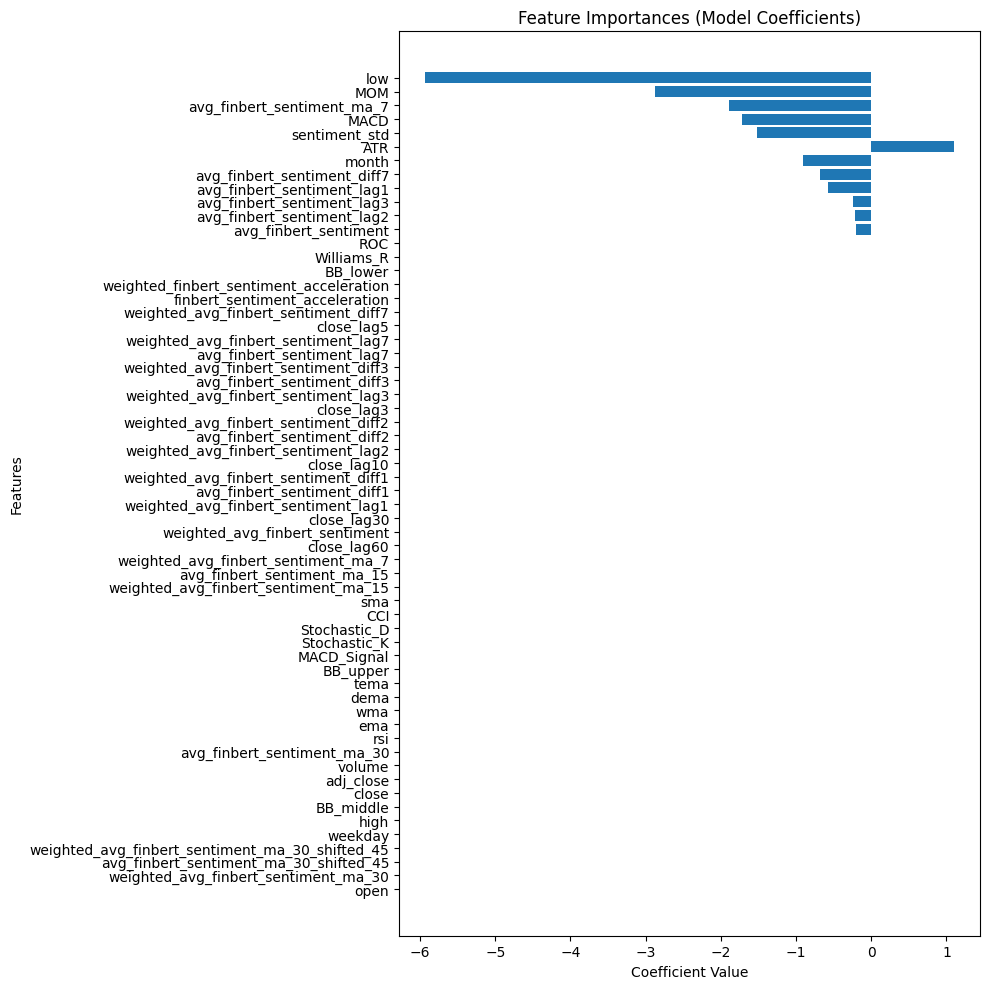

Train MAPE: 77254349437314.0312
Test MAPE: 2.8246
Train MSE: 133.6047
Test MSE: 432.4649


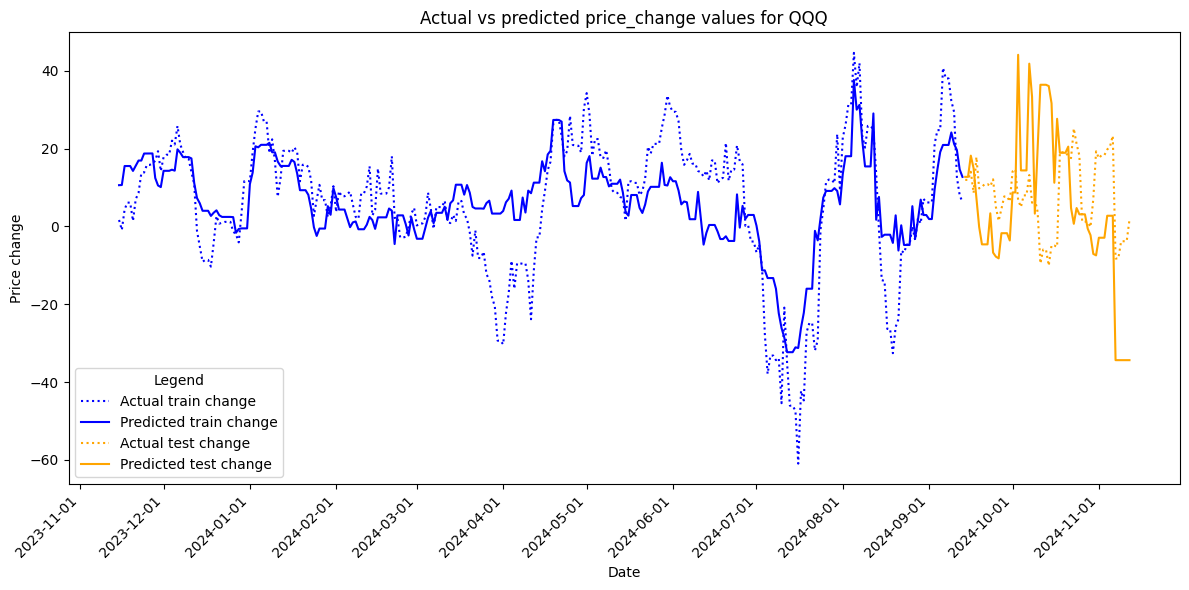

Restored train MAPE: 0.0202
Restored test MAPE: 0.0331
Restored train MSE: 133.6047
Restored test MSE: 432.4649


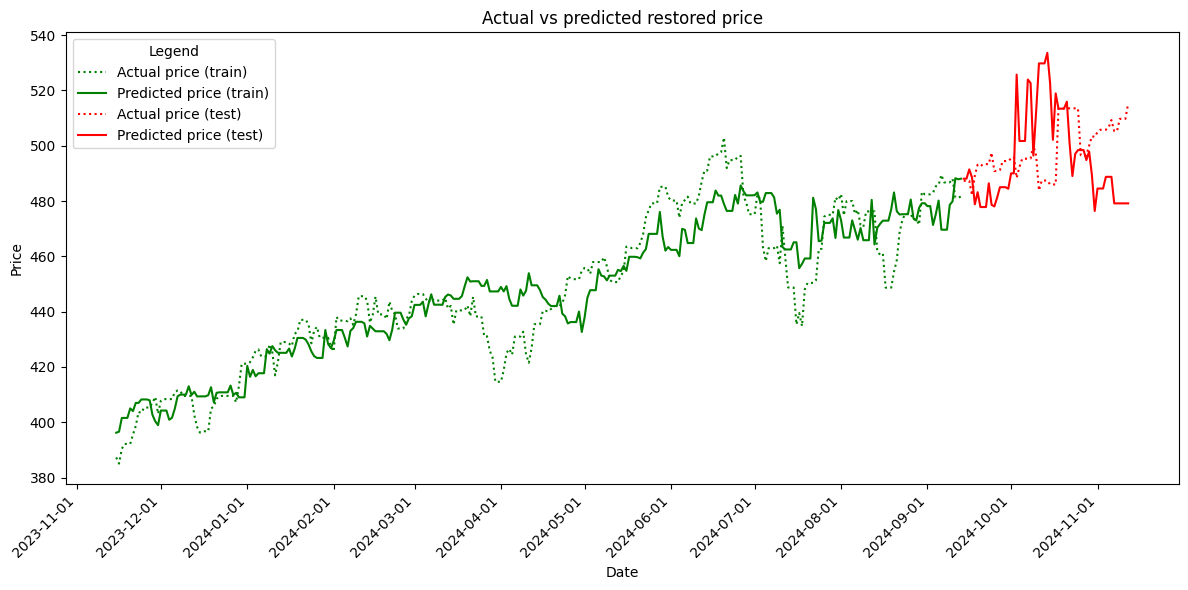

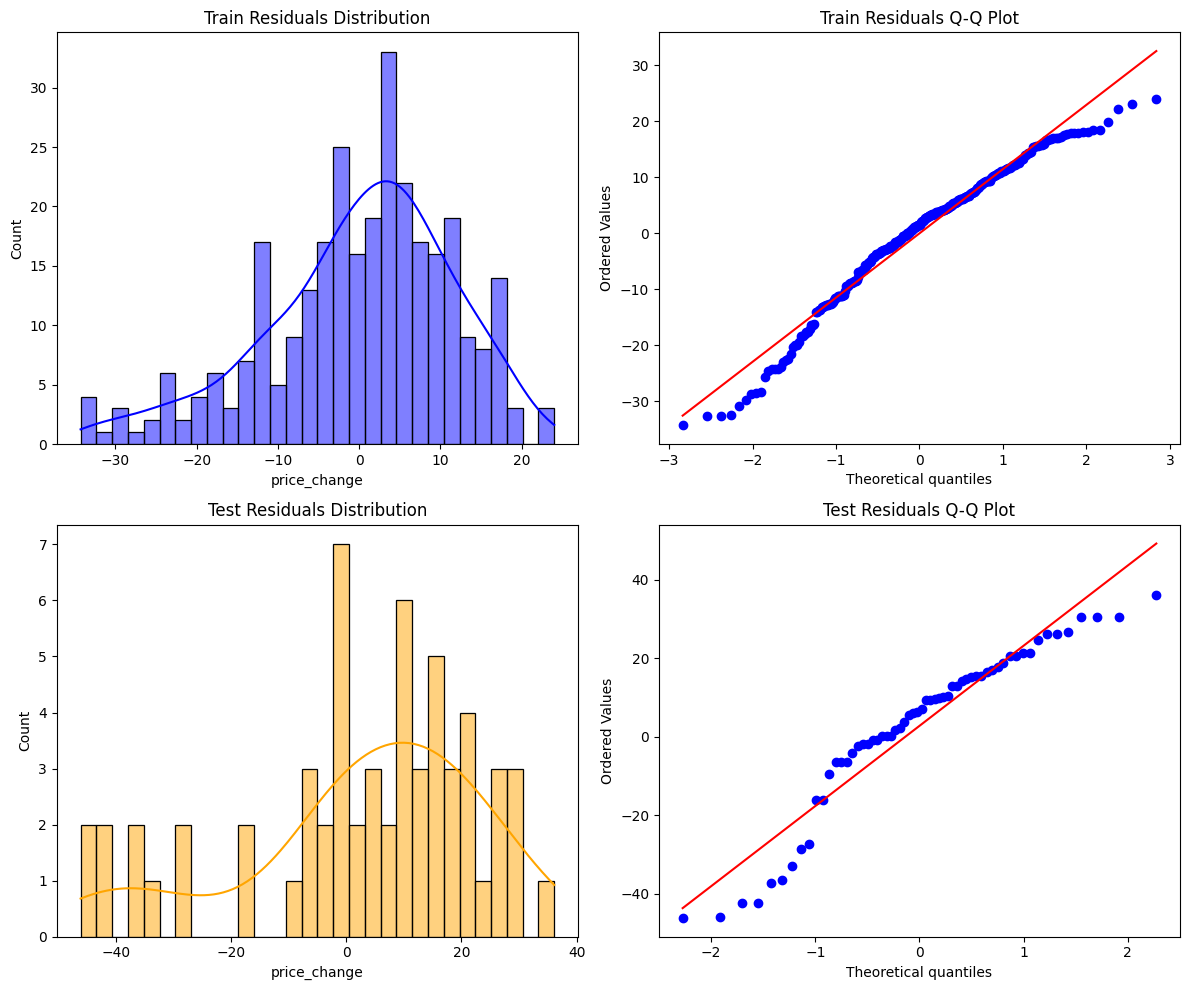

Shapiro-Wilk Test for Train Residuals: Statistic=0.9683, p-value=0.0000
Shapiro-Wilk Test for Test Residuals: Statistic=0.9163, p-value=0.0005


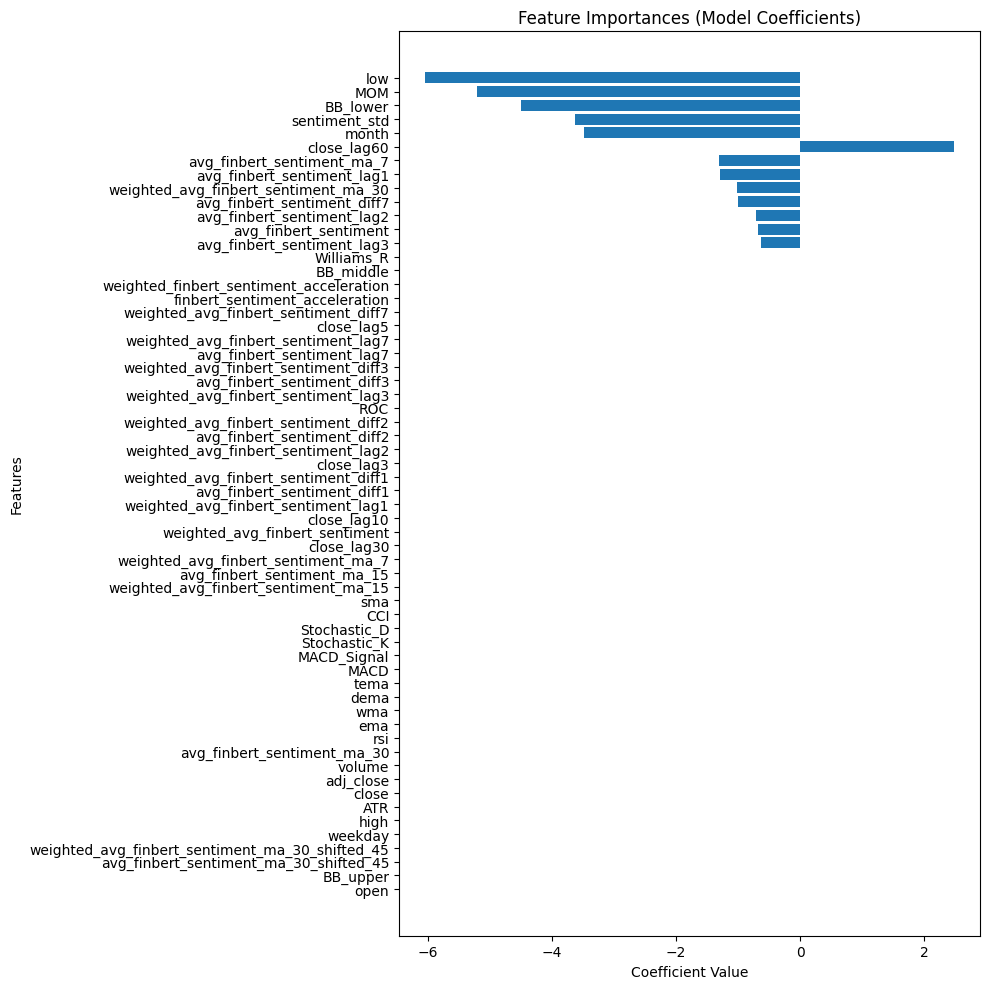

In [14]:
target = 'price_change'
test_len = 60
    
to_delete = [
    
# удаляем целевую переменную
    'price_change','next_day_close',
]

model = Lasso()
shift_days = 20

SPY_model, SPY_scaler, SPY_chosen_features = run_model(target, 'SPY', test_len, to_delete, model, shift_days,all_combinations)
QQQ_model, QQQ_scaler, QQQ_chosen_features = run_model(target, 'QQQ', test_len, to_delete, model, shift_days,all_combinations)

Все перечисленные ранее проблемы сохранились, модель обнулила большую часть признаков, при этом мы видим то, что амплитуда отклонений либо значительно слабее, либо предсказанное отклонение находится около нуля, модель просто не определяет связь признаков с поведением целевой переменной. Не смотря на то, что основные наибольшие всплески и падения модель зафиксировала, на тестовых данных все также наблюдаются интервалы с сильным смещением. Также в обоих случаях распределение остатков отличается от нормального. Вероятно проблема связана уже не столько со связию признаков и целевой переменной, сколько с природой признаков. Мы не извлекаем сущность, о которой в новостях идет речь, просто оцениваем сентимент. К примеру на осень 2024 года пришлись выборы президента США, и в данном случае информационный фон мог быть либо наполнен предположениями, либо спекуляцией. Новостей с проверенной информацией не могло быть до окончания выборов. Возможно, это внесло свое значительное смещение на стоимость индексов, как и сами результаты выборов, однако необходимо будет проверить это позднее, при большем объеме данных. 
 
Теперь обучим модели, которые предсказывают конечные значения цены и сохраним их результат, а также скейлер и набор признаков, который для этих моделей использовались.

In [58]:
# обучение на полном наборе данных
def final_model(target,ticker_name, test_len, to_delete, model, shift_days, all_combinations):
    # Подразумевается, что all_combinations уже загружен в пространство имён
    one_asset = all_combinations.loc[all_combinations.ticker == ticker_name]
    actual_data = one_asset.ffill()

    # Сдвигаем next_day_close на shift_days вперёд (с точки зрения прогноза)
    actual_data['next_day_close'] = actual_data['close'].shift(-shift_days)
    columns_to_shift = [col for col in actual_data.columns if col not in ['next_day_close', 'business_date']]

    # Расчёт изменения цены
    actual_data['price_change'] = actual_data['next_day_close'] - actual_data['close']
    actual_data = actual_data.dropna().reset_index(drop=True)

    # Формирование обучающей и тестовой выборки
    X_train = actual_data.drop(to_delete, axis=1, errors='ignore').select_dtypes(['int', 'float'])
    y_train = actual_data[target]
    chosen_features = X_train.columns
    
    dates_train = actual_data.business_date
    dates_test = actual_data.business_date

    # Добавляем стандартный скейлер
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Обучение модели
    model.fit(X_train_scaled, y_train)
    best_model = model

    # Предсказания
    y_train_pred = best_model.predict(X_train_scaled) 

    # Метрики
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)

    print(f"Train MAPE: {train_mape:.4f}")
    print(f"Train MSE: {train_mse:.4f}")

    # График целевой переменной 
    plt.figure(figsize=(12, 6))
    plt.plot(dates_train, y_train.values, label='Actual train change', color='blue', linestyle='dotted')
    plt.plot(dates_train, y_train_pred, label='Predicted train change', color='blue')

    plt.title(f"Actual vs predicted {target} values for {ticker_name}")
    plt.xlabel("Date")
    plt.ylabel("Price change")
    plt.legend(title="Legend")

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.gcf().autofmt_xdate(rotation=45)

    plt.tight_layout()
    plt.show()


    # Остатки
    residual_train = y_train - y_train_pred

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.histplot(residual_train, bins=30, kde=True, ax=axes[0], color='blue')
    axes[0].set_title('Train Residuals Distribution')
    stats.probplot(residual_train, dist="norm", plot=axes[1])
    axes[1].set_title('Train Residuals Q-Q Plot')

    plt.tight_layout()
    plt.show()

    shapiro_train = stats.shapiro(residual_train)

    print(f"Shapiro-Wilk Test for Train Residuals: Statistic={shapiro_train.statistic:.4f}, p-value={shapiro_train.pvalue:.4f}")
    
    return best_model, scaler, chosen_features

Train MAPE: 0.0303
Train MSE: 9.1701


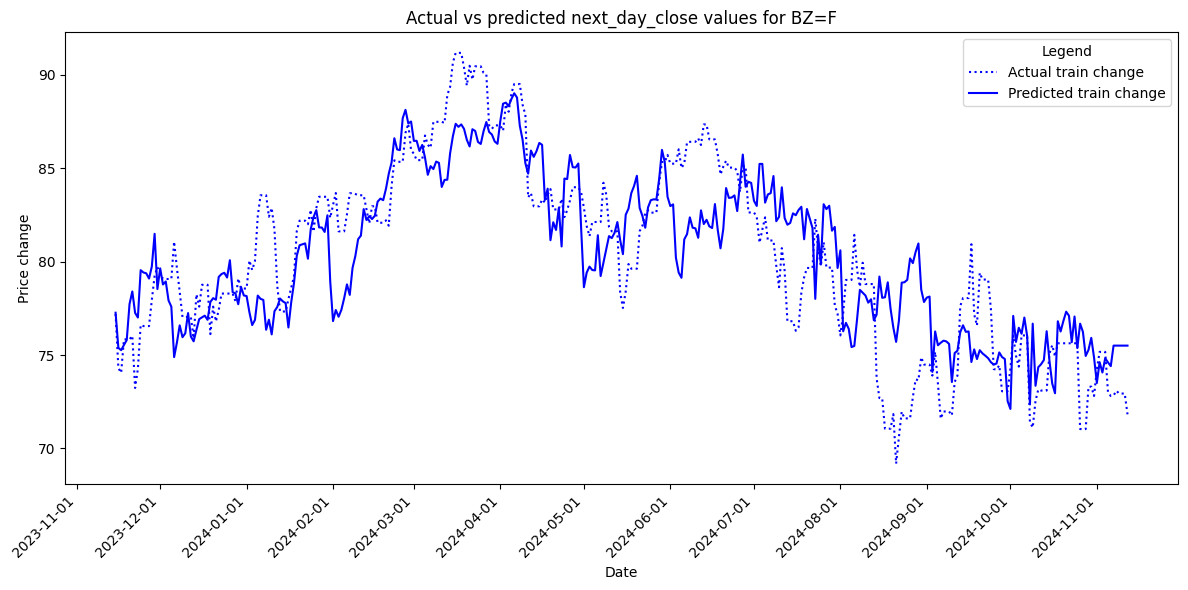

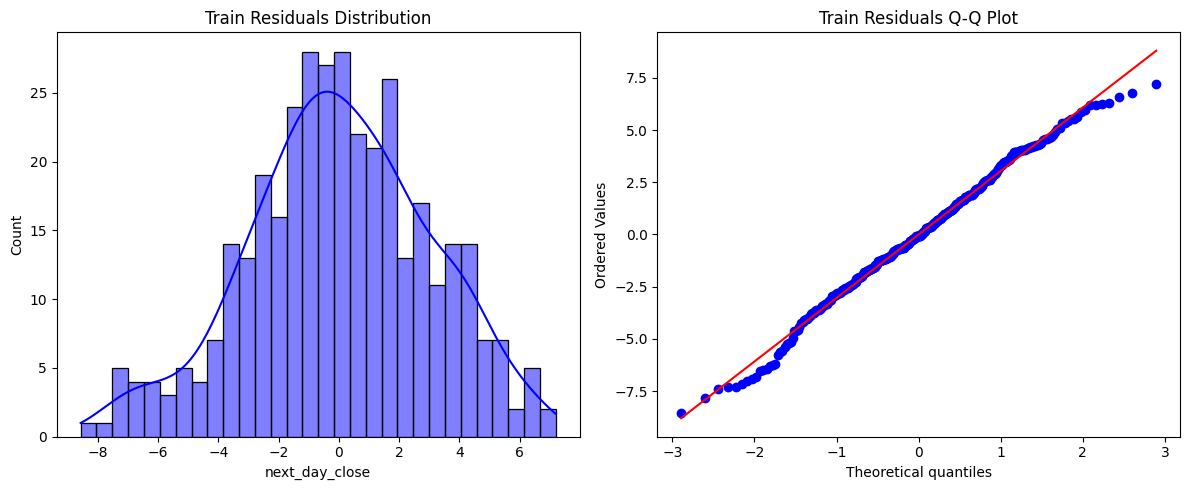

Shapiro-Wilk Test for Train Residuals: Statistic=0.9933, p-value=0.1063
Train MAPE: 0.0315
Train MSE: 8.6919


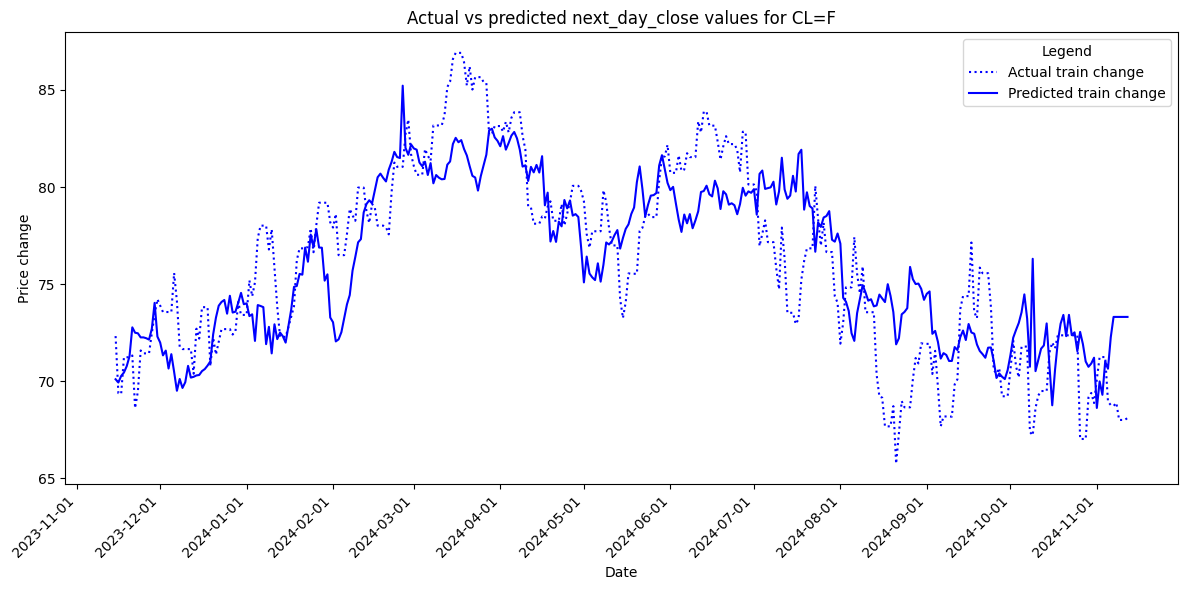

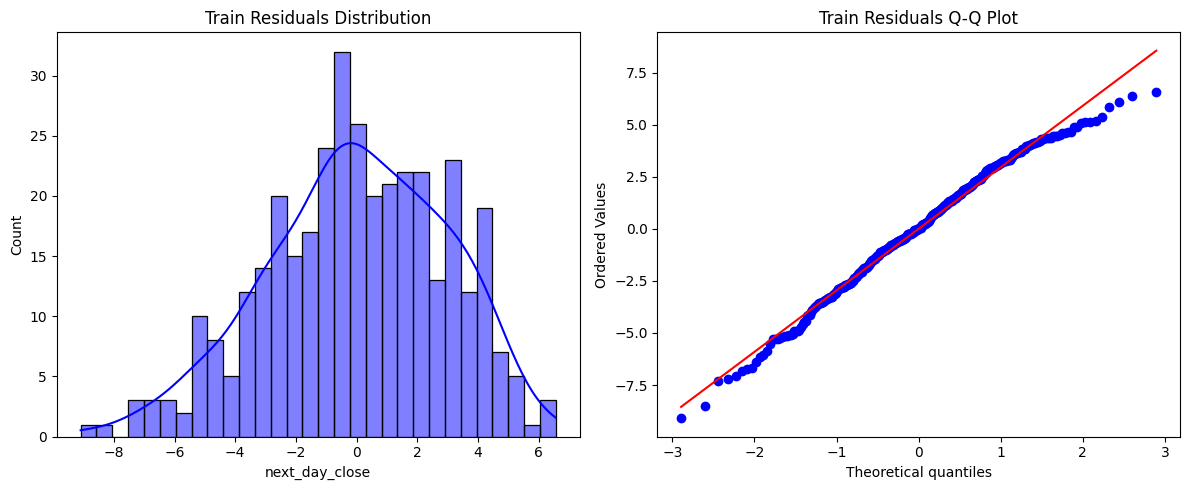

Shapiro-Wilk Test for Train Residuals: Statistic=0.9891, p-value=0.0084


In [70]:
BZ_F_model, BZ_F_scaler, BZ_F_chosen_features = final_model(target, 'BZ=F', test_len, to_delete, Ridge(), shift_days,all_combinations)
CL_F_model, CL_F_scaler, CL_F_chosen_features = final_model(target, 'CL=F', test_len, to_delete, Ridge(), shift_days,all_combinations)

Train MAPE: 0.0141
Train MSE: 92.6138


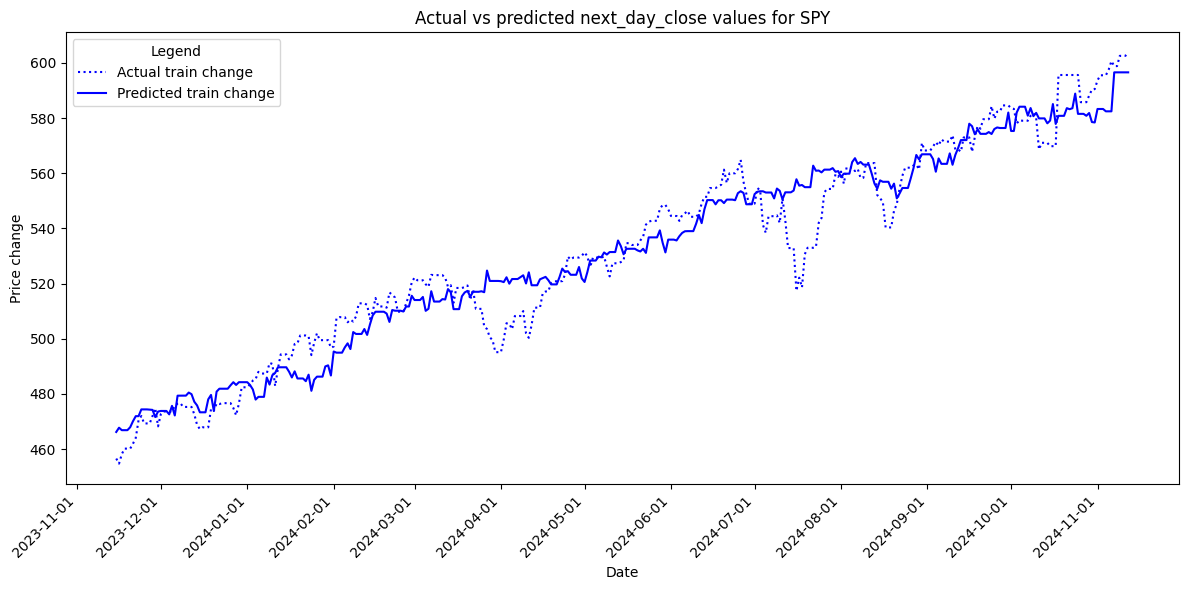

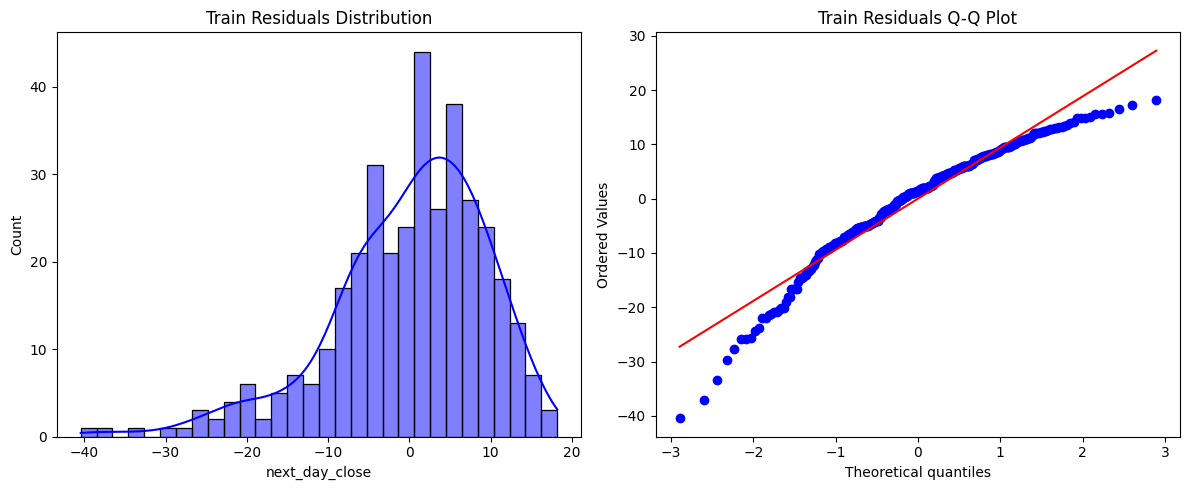

Shapiro-Wilk Test for Train Residuals: Statistic=0.9460, p-value=0.0000
Train MAPE: 0.0197
Train MSE: 130.9292


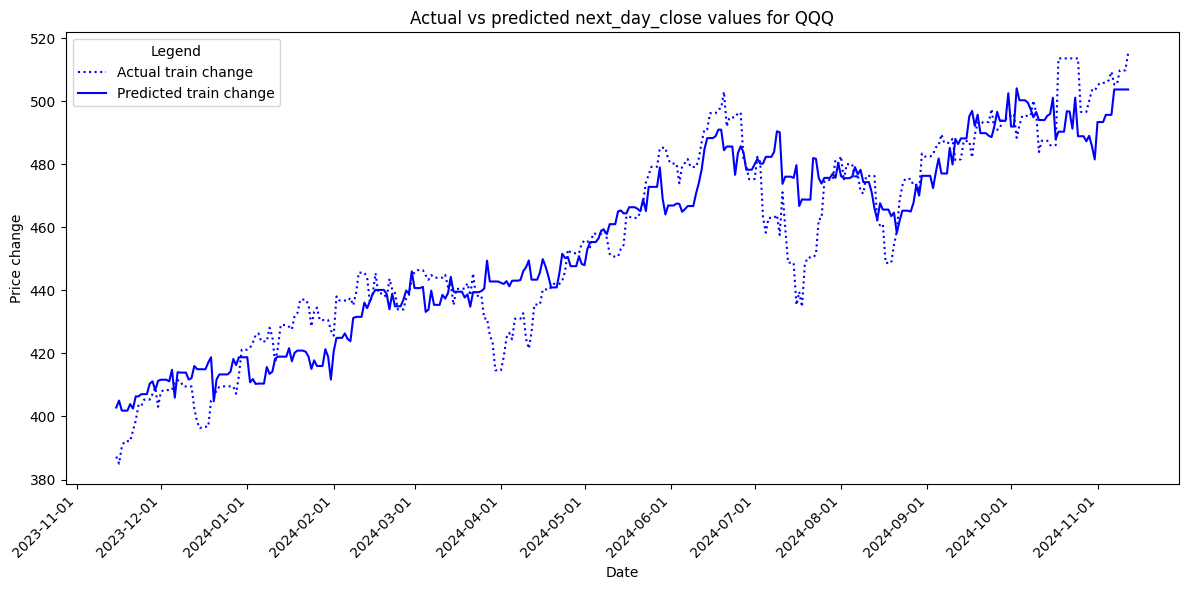

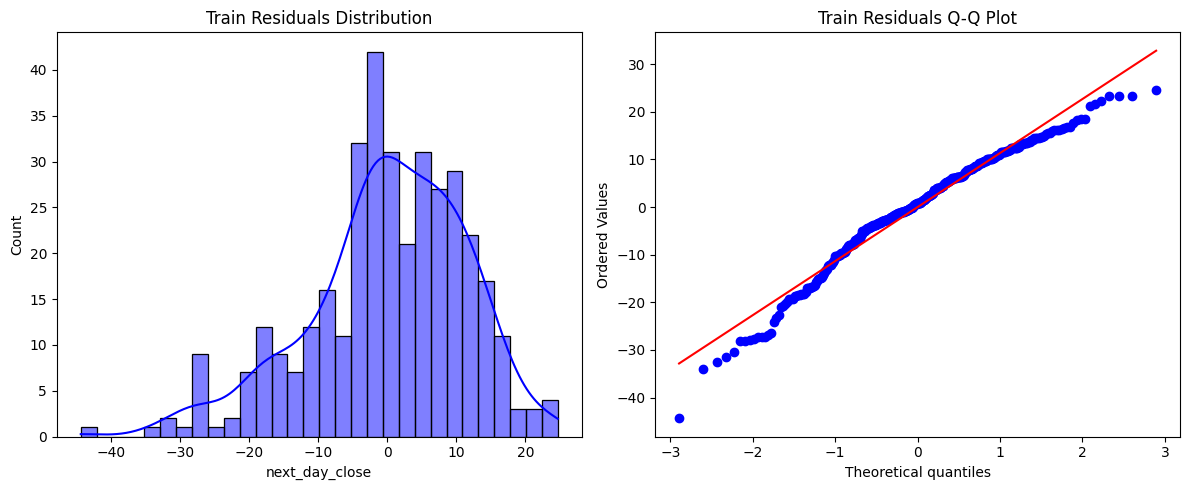

Shapiro-Wilk Test for Train Residuals: Statistic=0.9701, p-value=0.0000


In [71]:
SPY_model, SPY_scaler, SPY_chosen_features = final_model(target, 'SPY', test_len, to_delete, Ridge(), shift_days,all_combinations)
QQQ_model, QQQ_scaler, QQQ_chosen_features = final_model(target, 'QQQ', test_len, to_delete, Ridge(), shift_days,all_combinations)

In [74]:
import pickle


with open("SPY_model_bundle.pkl", "wb") as f:
    pickle.dump({"model": SPY_model, "scaler": SPY_scaler, "chosen_features": SPY_chosen_features}, f)
    
with open("QQQ_model_bundle.pkl", "wb") as f:
    pickle.dump({"model": QQQ_model, "scaler": QQQ_scaler, "chosen_features": QQQ_chosen_features}, f)

    
with open("CL_F_model_bundle.pkl", "wb") as f:
    pickle.dump({"model": CL_F_model, "scaler": CL_F_scaler, "chosen_features": CL_F_chosen_features}, f)
    
    
with open("BZ_F_model_bundle.pkl", "wb") as f:
    pickle.dump({"model": BZ_F_model, "scaler": BZ_F_scaler, "chosen_features": BZ_F_chosen_features}, f)
    
    
print("Done")

Done


### Общие выводы по всему процессу обучения. 

Для каждого из финансовых тикеров (CL=F, BZ=F, SPY, QQQ) сначала провалидирована отдельно на тестовых данных, потом обучена на полном объеме данных линейная модель. Во всех четырех случаях итоговой моделью была выбрана Ridge регрессия. Минимальный горизонт прогнозирования, на котором модель перестает предсказывать последние известные значения и адекватно понимает колебания разницы цен, это 20 дней.  Для каждой из моделей отобран набор признаков, при которых не происходит переобучения.  На тестовых данных по метрикам MAPE и MSE был достигнут удовлетворительный уровень. 

Важно отметить серьезные проблемы, которые все еще имеют место быть и не могут быть разрешены на тех признаках, которые были подготовлены  ранее. Это недостаточность информации для описания всей дисперсии, остаются серьезные отклонения на некоторых участках временных рядов, иногда амплитуда колебаний не соответствуют фактической, а иногда отсутствуют значительные сдвиги. Теоретически, это могло бы быть исправлено добавлением признаков о событиях в мире, либо выделением самой сущности из новостных источников, о которых идет речь.  

Для каждого тикера сохранены модель, скейлер и списки признаков.